# Part 1, Re-track IBB Index

If you have read the paper, you may notice that the first part of application in the paper is to select a subset of stocks from IBB Index to re-track the Index.


OK, let's start.

In [2]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

** Load data **

- `index_col = 0`: since first column is date (useless for training), let's keep it as index
- `dropna(axis=1, how='any')`: drop any stock with any n/a (missing) data
- `astype('float32')`: datatype

Finally we only have **83** stocks to use.

In [3]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('data/IVW_clean/IVW_last_price.csv', \
                       index_col=0,skiprows=np.arange(1,1055),header=0).dropna(axis=1, how='any').astype('float32')
stock_lp.index = pd.to_datetime(stock_lp.index)
stock['calibrate']['lp'] = stock_lp.iloc[0:1007, :]
stock['validate']['lp'] = stock_lp.iloc[1007:, :]

stock_net = pd.read_csv('data/IVW_clean/IVW_net_change.csv', \
                        index_col=0,skiprows=np.arange(1,1055),header=0,\
                        usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_net.index = pd.to_datetime(stock_net.index)
stock['calibrate']['net'] = stock_net.iloc[0:1007, :]
stock['validate']['net'] = stock_net.iloc[1007:, :]

stock_percentage = pd.read_csv('data/IVW_clean/IVW_percentage_change.csv', \
                               index_col=0,skiprows=np.arange(1,1055),header=0,\
                               usecols=np.append(stock_lp.columns.values,'date')).dropna(axis=1, how='any').astype('float32')
stock_percentage.index = pd.to_datetime(stock_percentage.index)
stock['calibrate']['percentage'] = stock_percentage.iloc[0:1007, :]
stock['validate']['percentage'] = stock_percentage.iloc[1007:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('data/IVW_clean/IVW.csv',index_col=0,skiprows=np.arange(1,1055),header=0).astype('float32')
ibb_full.index = pd.to_datetime(ibb_full.index)
ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:1007]
ibb['validate']['lp'] = ibb_lp[1007:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:1007]
ibb['validate']['net'] = ibb_net[1007:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:1007]
ibb['validate']['percentage'] = ibb_percentage[1007:]

- calibrate : 2014 to 2017, 1007 rows x 289 stocks
- validate: 2018 to 2019, 456 rows × 289 stocks

# Phase 1. Auto-encoding

1. Train an auto-encoder model compressing market information.
2. Rank stocks by 2-norm difference then select subset of them as our portfolio.
3. Page 7 of the paper: ReLU + linear as activation functions
4. Weights $W = (W_1, W_2)$, L2 regularization


Some problems I did not figure out (or the paper did not mention about the details):
1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. How to perform 4-fold validation in Deep Learning?

In [4]:
encoding_dim = 64 # 5 neurons
num_stock = len(stock_lp.columns) # Use 289 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=20000, batch_size = 40)
autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/20000
1007/1007 [==============================] - 0s 174us/step - loss: 10.4386
Epoch 2/20000
1007/1007 [==============================] - 0s 37us/step - loss: 9.0373
Epoch 3/20000
1007/1007 [==============================] - 0s 36us/step - loss: 8.1714
Epoch 4/20000
1007/1007 [==============================] - 0s 34us/step - loss: 7.3587
Epoch 5/20000
1007/1007 [==============================] - 0s 34us/step - loss: 6.6731
Epoch 6/20000
1007/1007 [==============================] - 0s 34us/step - loss: 6.1567
Epoch 7/20000
1007/1007 [==============================] - 0s 35us/step - loss: 5.7916
Epoch 8/20000
1007/1007 [==============================] - 0s 35us/step - loss: 5.5288
Epoch 9/20000
1007/1007 [==============================] - 0s 34us/step - loss: 5.3263
Epoch 10/20000
1007/1007 [==============================] - 0s 29us/step - loss: 5.1606
Epoch 11/20000
1007/1007 [==============================] - 0s 35us/step - loss: 5.0198
Epoch 12/20000
1007/1007 [=============

1007/1007 [==============================] - 0s 33us/step - loss: 2.2609
Epoch 94/20000
1007/1007 [==============================] - 0s 33us/step - loss: 2.2502
Epoch 95/20000
1007/1007 [==============================] - 0s 30us/step - loss: 2.2397
Epoch 96/20000
1007/1007 [==============================] - 0s 30us/step - loss: 2.2293
Epoch 97/20000
1007/1007 [==============================] - 0s 31us/step - loss: 2.2191
Epoch 98/20000
1007/1007 [==============================] - 0s 30us/step - loss: 2.2090
Epoch 99/20000
1007/1007 [==============================] - 0s 28us/step - loss: 2.1991
Epoch 100/20000
1007/1007 [==============================] - 0s 33us/step - loss: 2.1893
Epoch 101/20000
1007/1007 [==============================] - 0s 32us/step - loss: 2.1797
Epoch 102/20000
1007/1007 [==============================] - 0s 30us/step - loss: 2.1703
Epoch 103/20000
1007/1007 [==============================] - 0s 30us/step - loss: 2.1610
Epoch 104/20000
1007/1007 [================

1007/1007 [==============================] - 0s 25us/step - loss: 1.7066
Epoch 186/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.7035
Epoch 187/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.7004
Epoch 188/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.6973
Epoch 189/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.6943
Epoch 190/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.6913
Epoch 191/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.6884
Epoch 192/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.6855
Epoch 193/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.6826
Epoch 194/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.6798
Epoch 195/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.6770
Epoch 196/20000
1007/1007 [==========

Epoch 277/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.5268
Epoch 278/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.5257
Epoch 279/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.5245
Epoch 280/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.5234
Epoch 281/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.5223
Epoch 282/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.5212
Epoch 283/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.5202
Epoch 284/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.5191
Epoch 285/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.5180
Epoch 286/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.5170
Epoch 287/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.5160
Epoch 288/20000
1007/

1007/1007 [==============================] - 0s 30us/step - loss: 1.4582
Epoch 370/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.4577
Epoch 371/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4572
Epoch 372/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4568
Epoch 373/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4563
Epoch 374/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.4559
Epoch 375/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.4554
Epoch 376/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4550
Epoch 377/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4546
Epoch 378/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.4541
Epoch 379/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4537
Epoch 380/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 1.4285
Epoch 462/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4283
Epoch 463/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4281
Epoch 464/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4279
Epoch 465/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.4277
Epoch 466/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4275
Epoch 467/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4273
Epoch 468/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4271
Epoch 469/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4268
Epoch 470/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.4266
Epoch 471/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.4264
Epoch 472/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 28us/step - loss: 1.4136
Epoch 554/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4135
Epoch 555/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4134
Epoch 556/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4132
Epoch 557/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4131
Epoch 558/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4130
Epoch 559/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4129
Epoch 560/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4128
Epoch 561/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4126
Epoch 562/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4125
Epoch 563/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4124
Epoch 564/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 31us/step - loss: 1.4046
Epoch 646/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.4046
Epoch 647/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.4045
Epoch 648/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.4044
Epoch 649/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.4043
Epoch 650/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.4042
Epoch 651/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4042
Epoch 652/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.4041
Epoch 653/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4040
Epoch 654/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.4039
Epoch 655/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.4039
Epoch 656/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 29us/step - loss: 1.3984
Epoch 738/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3983
Epoch 739/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3983
Epoch 740/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3982
Epoch 741/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3982
Epoch 742/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3981
Epoch 743/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3980
Epoch 744/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3980
Epoch 745/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3979
Epoch 746/20000
1007/1007 [==============================] - 0s 36us/step - loss: 1.3979
Epoch 747/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3978
Epoch 748/20000
1007/1007 [==========

Epoch 829/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3935
Epoch 830/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3934
Epoch 831/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3934
Epoch 832/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3933
Epoch 833/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3933
Epoch 834/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3932
Epoch 835/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3932
Epoch 836/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3931
Epoch 837/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3931
Epoch 838/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3930
Epoch 839/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3930
Epoch 840/20000
1007/

1007/1007 [==============================] - 0s 30us/step - loss: 1.3894
Epoch 922/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3893
Epoch 923/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3893
Epoch 924/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3893
Epoch 925/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3892
Epoch 926/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3892
Epoch 927/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3891
Epoch 928/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3891
Epoch 929/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3891
Epoch 930/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3890
Epoch 931/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3890
Epoch 932/20000
1007/1007 [==========

1007/1007 [==============================] - 0s 30us/step - loss: 1.3859
Epoch 1014/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3859
Epoch 1015/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3858
Epoch 1016/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3858
Epoch 1017/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3858
Epoch 1018/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3857
Epoch 1019/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3857
Epoch 1020/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3857
Epoch 1021/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3856
Epoch 1022/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3856
Epoch 1023/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3855
Epoch 1024/20000
1007/1007 

1007/1007 [==============================] - 0s 29us/step - loss: 1.3829
Epoch 1105/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.3828
Epoch 1106/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3828
Epoch 1107/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3828
Epoch 1108/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3827
Epoch 1109/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3827
Epoch 1110/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3827
Epoch 1111/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3826
Epoch 1112/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3826
Epoch 1113/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3826
Epoch 1114/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.169 - 0s 28us/step - loss: 1.3825
Epo

Epoch 1195/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3801
Epoch 1196/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3801
Epoch 1197/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3800
Epoch 1198/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3800
Epoch 1199/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3800
Epoch 1200/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3799
Epoch 1201/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3799
Epoch 1202/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3799
Epoch 1203/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3799
Epoch 1204/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3798
Epoch 1205/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3798
Epoch 1206

1007/1007 [==============================] - 0s 23us/step - loss: 1.3775
Epoch 1287/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3775
Epoch 1288/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3775
Epoch 1289/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3775
Epoch 1290/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3774
Epoch 1291/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3774
Epoch 1292/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3774
Epoch 1293/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3773
Epoch 1294/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3773
Epoch 1295/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3773
Epoch 1296/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3773
Epoch 1297/20000
1007/1007 

Epoch 1377/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.3752
Epoch 1378/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3751
Epoch 1379/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3751
Epoch 1380/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3751
Epoch 1381/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3751
Epoch 1382/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3750
Epoch 1383/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3750
Epoch 1384/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3750
Epoch 1385/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.3750
Epoch 1386/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3749
Epoch 1387/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3749
Epoch 1388

1007/1007 [==============================] - 0s 24us/step - loss: 1.3729
Epoch 1469/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3729
Epoch 1470/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3729
Epoch 1471/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3729
Epoch 1472/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3728
Epoch 1473/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3728
Epoch 1474/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3728
Epoch 1475/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3728
Epoch 1476/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3727
Epoch 1477/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3727
Epoch 1478/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3727
Epoch 1479/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3708
Epoch 1560/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3708
Epoch 1561/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3708
Epoch 1562/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3708
Epoch 1563/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3707
Epoch 1564/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3707
Epoch 1565/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3707
Epoch 1566/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3707
Epoch 1567/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3707
Epoch 1568/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3706
Epoch 1569/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3706
Epoch 1570/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3688
Epoch 1651/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3688
Epoch 1652/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3688
Epoch 1653/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3687
Epoch 1654/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3687
Epoch 1655/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3687
Epoch 1656/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3687
Epoch 1657/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3687
Epoch 1658/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3686
Epoch 1659/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3686
Epoch 1660/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3686
Epoch 1661/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3669
Epoch 1742/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3669
Epoch 1743/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3669
Epoch 1744/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3668
Epoch 1745/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3668
Epoch 1746/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3668
Epoch 1747/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3668
Epoch 1748/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3668
Epoch 1749/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3667
Epoch 1750/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3667
Epoch 1751/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3667
Epoch 1752/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3650
Epoch 1833/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3650
Epoch 1834/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3650
Epoch 1835/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3650
Epoch 1836/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3650
Epoch 1837/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3649
Epoch 1838/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3649
Epoch 1839/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3649
Epoch 1840/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3649
Epoch 1841/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3649
Epoch 1842/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3648
Epoch 1843/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.3633
Epoch 1924/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3632
Epoch 1925/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3632
Epoch 1926/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3632
Epoch 1927/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3632
Epoch 1928/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3632
Epoch 1929/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3631
Epoch 1930/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3631
Epoch 1931/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3631
Epoch 1932/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3631
Epoch 1933/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3631
Epoch 1934/20000
1007/1007 

1007/1007 [==============================] - 0s 30us/step - loss: 1.3615
Epoch 2015/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3615
Epoch 2016/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3615
Epoch 2017/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3615
Epoch 2018/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3615
Epoch 2019/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3615
Epoch 2020/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3614
Epoch 2021/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3614
Epoch 2022/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3614
Epoch 2023/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3614
Epoch 2024/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3614
Epoch 2025/20000
1007/1007 

Epoch 2105/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3599
Epoch 2106/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3599
Epoch 2107/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3598
Epoch 2108/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3598
Epoch 2109/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3598
Epoch 2110/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3598
Epoch 2111/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3598
Epoch 2112/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3597
Epoch 2113/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3597
Epoch 2114/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3597
Epoch 2115/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3597
Epoch 2116

1007/1007 [==============================] - 0s 24us/step - loss: 1.3582
Epoch 2196/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3582
Epoch 2197/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3582
Epoch 2198/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3582
Epoch 2199/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3581
Epoch 2200/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3581
Epoch 2201/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3581
Epoch 2202/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3581
Epoch 2203/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3581
Epoch 2204/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3581
Epoch 2205/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3580
Epoch 2206/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3566
Epoch 2287/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3565
Epoch 2288/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3565
Epoch 2289/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3565
Epoch 2290/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3565
Epoch 2291/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3565
Epoch 2292/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3565
Epoch 2293/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3564
Epoch 2294/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3564
Epoch 2295/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3564
Epoch 2296/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3564
Epoch 2297/20000
1007/1007 

1007/1007 [==============================] - 0s 28us/step - loss: 1.3549
Epoch 2378/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3549
Epoch 2379/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3549
Epoch 2380/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3549
Epoch 2381/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3549
Epoch 2382/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3548
Epoch 2383/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3548
Epoch 2384/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3548
Epoch 2385/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3548
Epoch 2386/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3548
Epoch 2387/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3547
Epoch 2388/20000
1007/1007 

Epoch 2468/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3533
Epoch 2469/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3533
Epoch 2470/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3532
Epoch 2471/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3532
Epoch 2472/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3532
Epoch 2473/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3532
Epoch 2474/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3532
Epoch 2475/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3532
Epoch 2476/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3531
Epoch 2477/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3531
Epoch 2478/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3531
Epoch 2479

1007/1007 [==============================] - 0s 24us/step - loss: 1.3516
Epoch 2560/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3516
Epoch 2561/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3516
Epoch 2562/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3516
Epoch 2563/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3516
Epoch 2564/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3515
Epoch 2565/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3515
Epoch 2566/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3515
Epoch 2567/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3515
Epoch 2568/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3515
Epoch 2569/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3515
Epoch 2570/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3500
Epoch 2651/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3499
Epoch 2652/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3499
Epoch 2653/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3499
Epoch 2654/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3499
Epoch 2655/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3499
Epoch 2656/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.149 - 0s 24us/step - loss: 1.3499
Epoch 2657/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3498
Epoch 2658/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3498
Epoch 2659/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3498
Epoch 2660/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3498
Epo

1007/1007 [==============================] - 0s 23us/step - loss: 1.3483
Epoch 2741/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3483
Epoch 2742/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3483
Epoch 2743/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3483
Epoch 2744/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3483
Epoch 2745/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3482
Epoch 2746/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3482
Epoch 2747/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3482
Epoch 2748/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3482
Epoch 2749/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3482
Epoch 2750/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3481
Epoch 2751/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3467
Epoch 2832/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3466
Epoch 2833/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3466
Epoch 2834/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3466
Epoch 2835/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3466
Epoch 2836/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3466
Epoch 2837/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3466
Epoch 2838/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3465
Epoch 2839/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3465
Epoch 2840/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3465
Epoch 2841/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3465
Epoch 2842/20000
1007/1007 

Epoch 2922/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3450
Epoch 2923/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3450
Epoch 2924/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3450
Epoch 2925/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3450
Epoch 2926/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3449
Epoch 2927/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3449
Epoch 2928/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3449
Epoch 2929/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.145 - 0s 24us/step - loss: 1.3449
Epoch 2930/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3449
Epoch 2931/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3449
Epoch 2932/20000
1007/1007 [==============================] - 0s 23us/step -

1007/1007 [==============================] - 0s 24us/step - loss: 1.3434
Epoch 3013/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3434
Epoch 3014/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3433
Epoch 3015/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3433
Epoch 3016/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3433
Epoch 3017/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3433
Epoch 3018/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3433
Epoch 3019/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3432
Epoch 3020/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3432
Epoch 3021/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3432
Epoch 3022/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3432
Epoch 3023/20000
1007/1007 

1007/1007 [==============================] - 0s 23us/step - loss: 1.3417
Epoch 3104/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3417
Epoch 3105/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3417
Epoch 3106/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3416
Epoch 3107/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3416
Epoch 3108/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3416
Epoch 3109/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3416
Epoch 3110/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3416
Epoch 3111/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3416
Epoch 3112/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3415
Epoch 3113/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3415
Epoch 3114/20000
1007/1007 

Epoch 3194/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3401
Epoch 3195/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3400
Epoch 3196/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3400
Epoch 3197/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3400
Epoch 3198/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3400
Epoch 3199/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3400
Epoch 3200/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3400
Epoch 3201/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3399
Epoch 3202/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3399
Epoch 3203/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3399
Epoch 3204/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3399
Epoch 3205

1007/1007 [==============================] - 0s 24us/step - loss: 1.3384
Epoch 3286/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3384
Epoch 3287/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3384
Epoch 3288/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3384
Epoch 3289/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3384
Epoch 3290/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3383
Epoch 3291/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3383
Epoch 3292/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3383
Epoch 3293/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3383
Epoch 3294/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3383
Epoch 3295/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3382
Epoch 3296/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3368
Epoch 3376/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3368
Epoch 3377/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3368
Epoch 3378/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3367
Epoch 3379/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3367
Epoch 3380/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3367
Epoch 3381/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3367
Epoch 3382/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3367
Epoch 3383/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3367
Epoch 3384/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3366
Epoch 3385/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3366
Epoch 3386/20000
1007/1007 

1007/1007 [==============================] - 0s 23us/step - loss: 1.3352
Epoch 3467/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3351
Epoch 3468/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3351
Epoch 3469/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3351
Epoch 3470/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3351
Epoch 3471/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3351
Epoch 3472/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3351
Epoch 3473/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3350
Epoch 3474/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3350
Epoch 3475/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3350
Epoch 3476/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3350
Epoch 3477/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3336
Epoch 3558/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3335
Epoch 3559/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3335
Epoch 3560/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3335
Epoch 3561/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3335
Epoch 3562/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3335
Epoch 3563/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3335
Epoch 3564/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3334
Epoch 3565/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3334
Epoch 3566/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3334
Epoch 3567/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3334
Epoch 3568/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3319
Epoch 3649/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3319
Epoch 3650/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3319
Epoch 3651/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3319
Epoch 3652/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3319
Epoch 3653/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3318
Epoch 3654/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3318
Epoch 3655/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3318
Epoch 3656/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3318
Epoch 3657/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3318
Epoch 3658/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3317
Epoch 3659/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.3303
Epoch 3740/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3303
Epoch 3741/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3302
Epoch 3742/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3302
Epoch 3743/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3302
Epoch 3744/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3302
Epoch 3745/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3302
Epoch 3746/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3302
Epoch 3747/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3301
Epoch 3748/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3301
Epoch 3749/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3301
Epoch 3750/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.3286
Epoch 3831/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3286
Epoch 3832/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3286
Epoch 3833/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3286
Epoch 3834/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3286
Epoch 3835/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3285
Epoch 3836/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3285
Epoch 3837/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3285
Epoch 3838/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3285
Epoch 3839/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3285
Epoch 3840/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3285
Epoch 3841/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.3270
Epoch 3922/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3269
Epoch 3923/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3269
Epoch 3924/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3269
Epoch 3925/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3269
Epoch 3926/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3269
Epoch 3927/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3268
Epoch 3928/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.131 - 0s 24us/step - loss: 1.3268
Epoch 3929/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3268
Epoch 3930/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3268
Epoch 3931/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3268
Epo

1007/1007 [==============================] - 0s 24us/step - loss: 1.3253
Epoch 4012/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3252
Epoch 4013/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3252
Epoch 4014/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3252
Epoch 4015/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3252
Epoch 4016/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3252
Epoch 4017/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3251
Epoch 4018/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3251
Epoch 4019/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3251
Epoch 4020/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3251
Epoch 4021/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3251
Epoch 4022/20000
1007/1007 

Epoch 4102/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3235
Epoch 4103/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3235
Epoch 4104/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3235
Epoch 4105/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3235
Epoch 4106/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3234
Epoch 4107/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3234
Epoch 4108/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3234
Epoch 4109/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3234
Epoch 4110/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3234
Epoch 4111/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3233
Epoch 4112/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3233
Epoch 4113

1007/1007 [==============================] - 0s 24us/step - loss: 1.3218
Epoch 4193/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3218
Epoch 4194/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3218
Epoch 4195/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3217
Epoch 4196/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3217
Epoch 4197/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3217
Epoch 4198/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3217
Epoch 4199/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3217
Epoch 4200/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3216
Epoch 4201/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3216
Epoch 4202/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3216
Epoch 4203/20000
1007/1007 

1007/1007 [==============================] - 0s 23us/step - loss: 1.3201
Epoch 4284/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3200
Epoch 4285/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3200
Epoch 4286/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3200
Epoch 4287/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3200
Epoch 4288/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3200
Epoch 4289/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3199
Epoch 4290/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3199
Epoch 4291/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3199
Epoch 4292/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3199
Epoch 4293/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3199
Epoch 4294/20000
1007/1007 

1007/1007 [==============================] - 0s 34us/step - loss: 1.3183
Epoch 4374/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.3183
Epoch 4375/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3183
Epoch 4376/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3182
Epoch 4377/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3182
Epoch 4378/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3182
Epoch 4379/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3182
Epoch 4380/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3182
Epoch 4381/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3182
Epoch 4382/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3181
Epoch 4383/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3181
Epoch 4384/20000
1007/1007 

Epoch 4464/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3165
Epoch 4465/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3165
Epoch 4466/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3165
Epoch 4467/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3165
Epoch 4468/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3165
Epoch 4469/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3164
Epoch 4470/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3164
Epoch 4471/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3164
Epoch 4472/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3164
Epoch 4473/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3164
Epoch 4474/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3163
Epoch 4475

1007/1007 [==============================] - 0s 31us/step - loss: 1.3147
Epoch 4556/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3147
Epoch 4557/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3147
Epoch 4558/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3147
Epoch 4559/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3147
Epoch 4560/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3146
Epoch 4561/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3146
Epoch 4562/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3146
Epoch 4563/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3146
Epoch 4564/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3146
Epoch 4565/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.3145
Epoch 4566/20000
1007/1007 

Epoch 4646/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3130
Epoch 4647/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3129
Epoch 4648/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3129
Epoch 4649/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3129
Epoch 4650/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3129
Epoch 4651/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3129
Epoch 4652/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3129
Epoch 4653/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3128
Epoch 4654/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.3128
Epoch 4655/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3128
Epoch 4656/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3128
Epoch 4657

1007/1007 [==============================] - 0s 25us/step - loss: 1.3112
Epoch 4738/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3111
Epoch 4739/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3111
Epoch 4740/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3111
Epoch 4741/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3111
Epoch 4742/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3111
Epoch 4743/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3111
Epoch 4744/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3110
Epoch 4745/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3110
Epoch 4746/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3110
Epoch 4747/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3110
Epoch 4748/20000
1007/1007 

Epoch 4828/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3093
Epoch 4829/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3093
Epoch 4830/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3092
Epoch 4831/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3092
Epoch 4832/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3092
Epoch 4833/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3092
Epoch 4834/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3092
Epoch 4835/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3091
Epoch 4836/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3091
Epoch 4837/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3091
Epoch 4838/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3091
Epoch 4839

1007/1007 [==============================] - 0s 24us/step - loss: 1.3074
Epoch 4920/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3073
Epoch 4921/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3073
Epoch 4922/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3073
Epoch 4923/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3073
Epoch 4924/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3073
Epoch 4925/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3072
Epoch 4926/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3072
Epoch 4927/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3072
Epoch 4928/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3072
Epoch 4929/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3071
Epoch 4930/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.3054
Epoch 5011/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3054
Epoch 5012/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3054
Epoch 5013/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.3054
Epoch 5014/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3053
Epoch 5015/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3053
Epoch 5016/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3053
Epoch 5017/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.3053
Epoch 5018/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3052
Epoch 5019/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3052
Epoch 5020/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3052
Epoch 5021/20000
1007/1007 

Epoch 5101/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3034
Epoch 5102/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3034
Epoch 5103/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3034
Epoch 5104/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.3034
Epoch 5105/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3034
Epoch 5106/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3033
Epoch 5107/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3033
Epoch 5108/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3033
Epoch 5109/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3033
Epoch 5110/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3032
Epoch 5111/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3032
Epoch 5112

1007/1007 [==============================] - 0s 24us/step - loss: 1.3015
Epoch 5193/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3015
Epoch 5194/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3014
Epoch 5195/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3014
Epoch 5196/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3014
Epoch 5197/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3014
Epoch 5198/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3013
Epoch 5199/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.3013
Epoch 5200/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3013
Epoch 5201/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3013
Epoch 5202/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.3013
Epoch 5203/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.2994
Epoch 5284/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2994
Epoch 5285/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2994
Epoch 5286/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2994
Epoch 5287/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2994
Epoch 5288/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2993
Epoch 5289/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2993
Epoch 5290/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2993
Epoch 5291/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2993
Epoch 5292/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2992
Epoch 5293/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2992
Epoch 5294/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2974
Epoch 5375/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2974
Epoch 5376/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2973
Epoch 5377/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2973
Epoch 5378/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.107 - 0s 24us/step - loss: 1.2973
Epoch 5379/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2973
Epoch 5380/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2972
Epoch 5381/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2972
Epoch 5382/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2972
Epoch 5383/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2972
Epoch 5384/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2972
Epo

1007/1007 [==============================] - 0s 24us/step - loss: 1.2954
Epoch 5465/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2954
Epoch 5466/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2954
Epoch 5467/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2954
Epoch 5468/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2953
Epoch 5469/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2953
Epoch 5470/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2953
Epoch 5471/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2953
Epoch 5472/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2953
Epoch 5473/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2952
Epoch 5474/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2952
Epoch 5475/20000
1007/1007 

Epoch 5555/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2935
Epoch 5556/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2935
Epoch 5557/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2935
Epoch 5558/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2934
Epoch 5559/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2934
Epoch 5560/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2934
Epoch 5561/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2934
Epoch 5562/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2934
Epoch 5563/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2933
Epoch 5564/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2933
Epoch 5565/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2933
Epoch 5566

Epoch 5645/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2916
Epoch 5646/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2916
Epoch 5647/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2915
Epoch 5648/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2915
Epoch 5649/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2915
Epoch 5650/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2915
Epoch 5651/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2915
Epoch 5652/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2914
Epoch 5653/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2914
Epoch 5654/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2914
Epoch 5655/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2914
Epoch 5656

1007/1007 [==============================] - 0s 25us/step - loss: 1.2897
Epoch 5737/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2896
Epoch 5738/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2896
Epoch 5739/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2896
Epoch 5740/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2896
Epoch 5741/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2896
Epoch 5742/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2895
Epoch 5743/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2895
Epoch 5744/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2895
Epoch 5745/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2895
Epoch 5746/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2895
Epoch 5747/20000
1007/1007 

Epoch 5827/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2878
Epoch 5828/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2878
Epoch 5829/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2878
Epoch 5830/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2877
Epoch 5831/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2877
Epoch 5832/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2877
Epoch 5833/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2877
Epoch 5834/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2876
Epoch 5835/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2876
Epoch 5836/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2876
Epoch 5837/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2876
Epoch 5838

1007/1007 [==============================] - 0s 23us/step - loss: 1.2859
Epoch 5918/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2859
Epoch 5919/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2859
Epoch 5920/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2859
Epoch 5921/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2858
Epoch 5922/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2858
Epoch 5923/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2858
Epoch 5924/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2858
Epoch 5925/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2857
Epoch 5926/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2857
Epoch 5927/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2857
Epoch 5928/20000
1007/1007 

1007/1007 [==============================] - 0s 35us/step - loss: 1.2840
Epoch 6008/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2840
Epoch 6009/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2840
Epoch 6010/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2840
Epoch 6011/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2840
Epoch 6012/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2839
Epoch 6013/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2839
Epoch 6014/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2839
Epoch 6015/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2839
Epoch 6016/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2838
Epoch 6017/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2838
Epoch 6018/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.2821
Epoch 6099/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2821
Epoch 6100/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2820
Epoch 6101/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2820
Epoch 6102/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2820
Epoch 6103/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2820
Epoch 6104/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2819
Epoch 6105/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2819
Epoch 6106/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2819
Epoch 6107/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2819
Epoch 6108/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2819
Epoch 6109/20000
1007/1007 

1007/1007 [==============================] - 0s 29us/step - loss: 1.2802
Epoch 6189/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2802
Epoch 6190/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2802
Epoch 6191/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2801
Epoch 6192/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2801
Epoch 6193/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2801
Epoch 6194/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2801
Epoch 6195/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2801
Epoch 6196/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2800
Epoch 6197/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2800
Epoch 6198/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2800
Epoch 6199/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2784
Epoch 6280/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2783
Epoch 6281/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2783
Epoch 6282/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2783
Epoch 6283/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2783
Epoch 6284/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2783
Epoch 6285/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2782
Epoch 6286/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2782
Epoch 6287/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2782
Epoch 6288/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2782
Epoch 6289/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2782
Epoch 6290/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2766
Epoch 6371/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2766
Epoch 6372/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2765
Epoch 6373/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2765
Epoch 6374/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2765
Epoch 6375/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2765
Epoch 6376/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2765
Epoch 6377/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2764
Epoch 6378/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2764
Epoch 6379/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2764
Epoch 6380/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2764
Epoch 6381/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.2748
Epoch 6462/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2748
Epoch 6463/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2748
Epoch 6464/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2748
Epoch 6465/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2748
Epoch 6466/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2748
Epoch 6467/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2747
Epoch 6468/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2747
Epoch 6469/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2747
Epoch 6470/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2747
Epoch 6471/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2747
Epoch 6472/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2732
Epoch 6553/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2731
Epoch 6554/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2731
Epoch 6555/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2731
Epoch 6556/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2731
Epoch 6557/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2731
Epoch 6558/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2730
Epoch 6559/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2730
Epoch 6560/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2730
Epoch 6561/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2730
Epoch 6562/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2730
Epoch 6563/20000
1007/1007 

Epoch 6643/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2715
Epoch 6644/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2715
Epoch 6645/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2715
Epoch 6646/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2715
Epoch 6647/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2714
Epoch 6648/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2714
Epoch 6649/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2714
Epoch 6650/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2714
Epoch 6651/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2714
Epoch 6652/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2713
Epoch 6653/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2713
Epoch 6654

1007/1007 [==============================] - 0s 24us/step - loss: 1.2699
Epoch 6734/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2699
Epoch 6735/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2699
Epoch 6736/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2698
Epoch 6737/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2698
Epoch 6738/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2698
Epoch 6739/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2698
Epoch 6740/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2698
Epoch 6741/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2697
Epoch 6742/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2697
Epoch 6743/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2697
Epoch 6744/20000
1007/1007 

Epoch 6824/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2683
Epoch 6825/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2682
Epoch 6826/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2682
Epoch 6827/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2682
Epoch 6828/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2682
Epoch 6829/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2682
Epoch 6830/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2682
Epoch 6831/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2681
Epoch 6832/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2681
Epoch 6833/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2681
Epoch 6834/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2681
Epoch 6835

1007/1007 [==============================] - 0s 23us/step - loss: 1.2667
Epoch 6916/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2666
Epoch 6917/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2666
Epoch 6918/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2666
Epoch 6919/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2666
Epoch 6920/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2666
Epoch 6921/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2666
Epoch 6922/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.2665
Epoch 6923/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2665
Epoch 6924/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2665
Epoch 6925/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2665
Epoch 6926/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2651
Epoch 7006/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2651
Epoch 7007/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2651
Epoch 7008/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2650
Epoch 7009/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2650
Epoch 7010/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2650
Epoch 7011/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2650
Epoch 7012/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2650
Epoch 7013/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2650
Epoch 7014/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2649
Epoch 7015/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2649
Epoch 7016/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2635
Epoch 7097/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2635
Epoch 7098/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2635
Epoch 7099/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2635
Epoch 7100/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2635
Epoch 7101/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2634
Epoch 7102/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2634
Epoch 7103/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2634
Epoch 7104/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2634
Epoch 7105/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2634
Epoch 7106/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2634
Epoch 7107/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2620
Epoch 7188/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.083 - 0s 24us/step - loss: 1.2620
Epoch 7189/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2620
Epoch 7190/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2619
Epoch 7191/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2619
Epoch 7192/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2619
Epoch 7193/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2619
Epoch 7194/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2619
Epoch 7195/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2619
Epoch 7196/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2618
Epoch 7197/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2618
Epo

1007/1007 [==============================] - 0s 24us/step - loss: 1.2605
Epoch 7278/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2605
Epoch 7279/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2605
Epoch 7280/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2605
Epoch 7281/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7282/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7283/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7284/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7285/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7286/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2604
Epoch 7287/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2603
Epoch 7288/20000
1007/1007 

1007/1007 [==============================] - 0s 23us/step - loss: 1.2590
Epoch 7368/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2590
Epoch 7369/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2590
Epoch 7370/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2590
Epoch 7371/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2590
Epoch 7372/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2590
Epoch 7373/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2589
Epoch 7374/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2589
Epoch 7375/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2589
Epoch 7376/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2589
Epoch 7377/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2589
Epoch 7378/20000
1007/1007 

Epoch 7458/20000
1007/1007 [==============================] - 0s 22us/step - loss: 1.2576
Epoch 7459/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2575
Epoch 7460/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2575
Epoch 7461/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2575
Epoch 7462/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2575
Epoch 7463/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2575
Epoch 7464/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2575
Epoch 7465/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2574
Epoch 7466/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2574
Epoch 7467/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2574
Epoch 7468/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2574
Epoch 7469

1007/1007 [==============================] - 0s 23us/step - loss: 1.2561
Epoch 7549/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2561
Epoch 7550/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2561
Epoch 7551/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2561
Epoch 7552/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2561
Epoch 7553/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2561
Epoch 7554/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2560
Epoch 7555/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2560
Epoch 7556/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2560
Epoch 7557/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2560
Epoch 7558/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2560
Epoch 7559/20000
1007/1007 

Epoch 7639/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2547
Epoch 7640/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2547
Epoch 7641/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2547
Epoch 7642/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2547
Epoch 7643/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2546
Epoch 7644/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2546
Epoch 7645/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2546
Epoch 7646/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2546
Epoch 7647/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2546
Epoch 7648/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2546
Epoch 7649/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2546
Epoch 7650

1007/1007 [==============================] - 0s 23us/step - loss: 1.2533
Epoch 7730/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2533
Epoch 7731/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2533
Epoch 7732/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2532
Epoch 7733/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2532
Epoch 7734/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2532
Epoch 7735/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2532
Epoch 7736/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2532
Epoch 7737/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2532
Epoch 7738/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2532
Epoch 7739/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2531
Epoch 7740/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2519
Epoch 7821/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2519
Epoch 7822/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2518
Epoch 7823/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2518
Epoch 7824/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2518
Epoch 7825/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2518
Epoch 7826/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2518
Epoch 7827/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2518
Epoch 7828/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2518
Epoch 7829/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2517
Epoch 7830/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2517
Epoch 7831/20000
1007/1007 

Epoch 7911/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2505
Epoch 7912/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2505
Epoch 7913/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2505
Epoch 7914/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2504
Epoch 7915/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2504
Epoch 7916/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2504
Epoch 7917/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2504
Epoch 7918/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2504
Epoch 7919/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2504
Epoch 7920/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2504
Epoch 7921/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2503
Epoch 7922

1007/1007 [==============================] - 0s 24us/step - loss: 1.2491
Epoch 8002/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2491
Epoch 8003/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2491
Epoch 8004/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2491
Epoch 8005/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2491
Epoch 8006/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2491
Epoch 8007/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2491
Epoch 8008/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2490
Epoch 8009/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2490
Epoch 8010/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2490
Epoch 8011/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2490
Epoch 8012/20000
1007/1007 

Epoch 8092/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2478
Epoch 8093/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2478
Epoch 8094/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2478
Epoch 8095/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2478
Epoch 8096/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2477
Epoch 8097/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2477
Epoch 8098/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2477
Epoch 8099/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2477
Epoch 8100/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2477
Epoch 8101/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2477
Epoch 8102/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2476
Epoch 8103

1007/1007 [==============================] - 0s 23us/step - loss: 1.2465
Epoch 8182/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2465
Epoch 8183/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2465
Epoch 8184/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2465
Epoch 8185/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2464
Epoch 8186/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2464
Epoch 8187/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2464
Epoch 8188/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2464
Epoch 8189/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2464
Epoch 8190/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2464
Epoch 8191/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2464
Epoch 8192/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2452
Epoch 8273/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2452
Epoch 8274/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2452
Epoch 8275/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2452
Epoch 8276/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2452
Epoch 8277/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2451
Epoch 8278/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2451
Epoch 8279/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2451
Epoch 8280/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2451
Epoch 8281/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2451
Epoch 8282/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2451
Epoch 8283/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2440
Epoch 8364/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2439
Epoch 8365/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2439
Epoch 8366/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2439
Epoch 8367/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2439
Epoch 8368/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2439
Epoch 8369/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2439
Epoch 8370/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2439
Epoch 8371/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2438
Epoch 8372/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2438
Epoch 8373/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2438
Epoch 8374/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8455/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8456/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8457/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8458/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8459/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2427
Epoch 8460/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2426
Epoch 8461/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2426
Epoch 8462/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2426
Epoch 8463/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2426
Epoch 8464/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2426
Epoch 8465/20000
1007/1007 

1007/1007 [==============================] - 0s 26us/step - loss: 1.2415
Epoch 8545/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2415
Epoch 8546/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2415
Epoch 8547/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2415
Epoch 8548/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2415
Epoch 8549/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2415
Epoch 8550/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2414
Epoch 8551/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2414
Epoch 8552/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2414
Epoch 8553/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2414
Epoch 8554/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2414
Epoch 8555/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2403
Epoch 8636/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2403
Epoch 8637/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2403
Epoch 8638/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2403
Epoch 8639/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2403
Epoch 8640/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2403
Epoch 8641/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2402
Epoch 8642/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2402
Epoch 8643/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2402
Epoch 8644/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2402
Epoch 8645/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2402
Epoch 8646/20000
1007/1007 

1007/1007 [==============================] - 0s 26us/step - loss: 1.2392
Epoch 8726/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2391
Epoch 8727/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2391
Epoch 8728/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2391
Epoch 8729/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2391
Epoch 8730/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2391
Epoch 8731/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2391
Epoch 8732/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2391
Epoch 8733/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2391
Epoch 8734/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2390
Epoch 8735/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2390
Epoch 8736/20000
1007/1007 

Epoch 8816/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2380
Epoch 8817/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2380
Epoch 8818/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2380
Epoch 8819/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2380
Epoch 8820/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2380
Epoch 8821/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.2379
Epoch 8822/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.2379
Epoch 8823/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2379
Epoch 8824/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2379
Epoch 8825/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2379
Epoch 8826/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2379
Epoch 8827

1007/1007 [==============================] - 0s 24us/step - loss: 1.2369
Epoch 8908/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2369
Epoch 8909/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2369
Epoch 8910/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2368
Epoch 8911/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2368
Epoch 8912/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2368
Epoch 8913/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2368
Epoch 8914/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2368
Epoch 8915/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2368
Epoch 8916/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2368
Epoch 8917/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2368
Epoch 8918/20000
1007/1007 

1007/1007 [==============================] - 0s 26us/step - loss: 1.2358
Epoch 8999/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2358
Epoch 9000/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2358
Epoch 9001/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2358
Epoch 9002/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2357
Epoch 9003/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9004/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9005/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9006/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9007/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9008/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2357
Epoch 9009/20000
1007/1007 

1007/1007 [==============================] - 0s 31us/step - loss: 1.2347
Epoch 9090/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2347
Epoch 9091/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2347
Epoch 9092/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.2347
Epoch 9093/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.2347
Epoch 9094/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2347
Epoch 9095/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2346
Epoch 9096/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.2346
Epoch 9097/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.2346
Epoch 9098/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.2346
Epoch 9099/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.2346
Epoch 9100/20000
1007/1007 

Epoch 9180/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2337
Epoch 9181/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2336
Epoch 9182/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2336
Epoch 9183/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2336
Epoch 9184/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2336
Epoch 9185/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2336
Epoch 9186/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2336
Epoch 9187/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2336
Epoch 9188/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2336
Epoch 9189/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2335
Epoch 9190/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2335
Epoch 9191

1007/1007 [==============================] - 0s 24us/step - loss: 1.2326
Epoch 9272/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2326
Epoch 9273/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2326
Epoch 9274/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2326
Epoch 9275/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2326
Epoch 9276/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2326
Epoch 9277/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2325
Epoch 9278/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2325
Epoch 9279/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2325
Epoch 9280/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2325
Epoch 9281/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2325
Epoch 9282/20000
1007/1007 

1007/1007 [==============================] - 0s 35us/step - loss: 1.2316
Epoch 9362/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2316
Epoch 9363/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9364/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9365/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2315
Epoch 9366/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9367/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2315
Epoch 9368/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2315
Epoch 9369/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9370/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9371/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2315
Epoch 9372/20000
1007/1007 

1007/1007 [==============================] - 0s 25us/step - loss: 1.2305
Epoch 9453/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2305
Epoch 9454/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2305
Epoch 9455/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2305
Epoch 9456/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2305
Epoch 9457/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2305
Epoch 9458/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2305
Epoch 9459/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2305
Epoch 9460/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2304
Epoch 9461/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2304
Epoch 9462/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2304
Epoch 9463/20000
1007/1007 

1007/1007 [==============================] - 0s 23us/step - loss: 1.2295
Epoch 9544/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2295
Epoch 9545/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2295
Epoch 9546/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2295
Epoch 9547/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2295
Epoch 9548/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2295
Epoch 9549/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2294
Epoch 9550/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2294
Epoch 9551/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2294
Epoch 9552/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2294
Epoch 9553/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2294
Epoch 9554/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2285
Epoch 9635/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2285
Epoch 9636/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2285
Epoch 9637/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2285
Epoch 9638/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2285
Epoch 9639/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2285
Epoch 9640/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2285
Epoch 9641/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2285
Epoch 9642/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2284
Epoch 9643/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2284
Epoch 9644/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2284
Epoch 9645/20000
1007/1007 

Epoch 9725/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2276
Epoch 9726/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2276
Epoch 9727/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2276
Epoch 9728/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2275
Epoch 9729/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2275
Epoch 9730/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2275
Epoch 9731/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2275
Epoch 9732/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2275
Epoch 9733/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.2275
Epoch 9734/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.2275
Epoch 9735/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2275
Epoch 9736

1007/1007 [==============================] - 0s 24us/step - loss: 1.2266
Epoch 9817/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2266
Epoch 9818/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2266
Epoch 9819/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2266
Epoch 9820/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2266
Epoch 9821/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2266
Epoch 9822/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2266
Epoch 9823/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2266
Epoch 9824/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2265
Epoch 9825/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2265
Epoch 9826/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2265
Epoch 9827/20000
1007/1007 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2257
Epoch 9908/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2257
Epoch 9909/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2257
Epoch 9910/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2257
Epoch 9911/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2257
Epoch 9912/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2256
Epoch 9913/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2256
Epoch 9914/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2256
Epoch 9915/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2256
Epoch 9916/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2256
Epoch 9917/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2256
Epoch 9918/20000
1007/1007 

Epoch 9998/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2248
Epoch 9999/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2248
Epoch 10000/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2248
Epoch 10001/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2247
Epoch 10002/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2247
Epoch 10003/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2247
Epoch 10004/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2247
Epoch 10005/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2247
Epoch 10006/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2247
Epoch 10007/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2247
Epoch 10008/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2247
E

1007/1007 [==============================] - 0s 24us/step - loss: 1.2239
Epoch 10087/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.2239
Epoch 10088/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2239
Epoch 10089/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2239
Epoch 10090/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2239
Epoch 10091/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2238
Epoch 10092/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2238
Epoch 10093/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2238
Epoch 10094/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2238
Epoch 10095/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2238
Epoch 10096/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2238
Epoch 10097/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2230
Epoch 10176/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2230
Epoch 10177/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2230
Epoch 10178/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2230
Epoch 10179/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2230
Epoch 10180/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2229
Epoch 10181/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2229
Epoch 10182/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2229
Epoch 10183/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2229
Epoch 10184/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2229
Epoch 10185/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2229
Epoch 10186/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2221
Epoch 10266/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2221
Epoch 10267/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2221
Epoch 10268/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2221
Epoch 10269/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2221
Epoch 10270/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2221
Epoch 10271/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2220
Epoch 10272/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2220
Epoch 10273/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2220
Epoch 10274/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2220
Epoch 10275/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2220
Epoch 10276/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2212
Epoch 10356/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2212
Epoch 10357/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2212
Epoch 10358/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2212
Epoch 10359/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2212
Epoch 10360/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2211
Epoch 10361/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2211
Epoch 10362/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2211
Epoch 10363/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2211
Epoch 10364/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2211
Epoch 10365/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2211
Epoch 10366/20000

Epoch 10445/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2203
Epoch 10446/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2203
Epoch 10447/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2203
Epoch 10448/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2203
Epoch 10449/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2203
Epoch 10450/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2203
Epoch 10451/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2203
Epoch 10452/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2202
Epoch 10453/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2202
Epoch 10454/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2202
Epoch 10455/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2202

1007/1007 [==============================] - 0s 23us/step - loss: 1.2195
Epoch 10536/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2194
Epoch 10537/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2194
Epoch 10538/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2194
Epoch 10539/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2194
Epoch 10540/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2194
Epoch 10541/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2194
Epoch 10542/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2194
Epoch 10543/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2194
Epoch 10544/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2194
Epoch 10545/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2194
Epoch 10546/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2186
Epoch 10626/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2186
Epoch 10627/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2186
Epoch 10628/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2186
Epoch 10629/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2185
Epoch 10630/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2185
Epoch 10631/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2185
Epoch 10632/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2185
Epoch 10633/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2185
Epoch 10634/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2185
Epoch 10635/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2185
Epoch 10636/20000

Epoch 10715/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2177
Epoch 10716/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2177
Epoch 10717/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2177
Epoch 10718/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2177
Epoch 10719/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2177
Epoch 10720/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2177
Epoch 10721/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2177
Epoch 10722/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2177
Epoch 10723/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2177
Epoch 10724/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2176
Epoch 10725/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2176

1007/1007 [==============================] - 0s 24us/step - loss: 1.2169
Epoch 10806/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2169
Epoch 10807/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2169
Epoch 10808/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2169
Epoch 10809/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2169
Epoch 10810/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2169
Epoch 10811/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2168
Epoch 10812/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2168
Epoch 10813/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2168
Epoch 10814/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2168
Epoch 10815/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2168
Epoch 10816/20000

Epoch 10895/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2161
Epoch 10896/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2161
Epoch 10897/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2161
Epoch 10898/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2161
Epoch 10899/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2161
Epoch 10900/20000
1007/1007 [==============================] - 0s 22us/step - loss: 1.2161
Epoch 10901/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2160
Epoch 10902/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2160
Epoch 10903/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2160
Epoch 10904/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2160
Epoch 10905/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2160

1007/1007 [==============================] - 0s 24us/step - loss: 1.2153
Epoch 10986/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2153
Epoch 10987/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2153
Epoch 10988/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2153
Epoch 10989/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2153
Epoch 10990/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2153
Epoch 10991/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2153
Epoch 10992/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2152
Epoch 10993/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2152
Epoch 10994/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2152
Epoch 10995/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2152
Epoch 10996/20000

Epoch 11075/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11076/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11077/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11078/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11079/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11080/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145
Epoch 11081/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2145
Epoch 11082/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2145
Epoch 11083/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2145
Epoch 11084/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2145
Epoch 11085/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2145

1007/1007 [==============================] - 0s 23us/step - loss: 1.2138
Epoch 11166/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2138
Epoch 11167/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2138
Epoch 11168/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2138
Epoch 11169/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11170/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11171/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2137
Epoch 11172/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11173/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11174/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11175/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2137
Epoch 11176/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11256/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11257/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11258/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2130
Epoch 11259/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11260/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2130
Epoch 11261/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11262/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2130
Epoch 11263/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2130
Epoch 11264/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2130
Epoch 11265/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2129
Epoch 11266/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2123
Epoch 11346/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2123
Epoch 11347/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2123
Epoch 11348/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2123
Epoch 11349/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2123
Epoch 11350/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2123
Epoch 11351/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2123
Epoch 11352/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2122
Epoch 11353/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2122
Epoch 11354/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2122
Epoch 11355/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2122
Epoch 11356/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2116
Epoch 11436/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2116
Epoch 11437/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2116
Epoch 11438/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2116
Epoch 11439/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2116
Epoch 11440/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2116
Epoch 11441/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2116
Epoch 11442/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2115
Epoch 11443/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2115
Epoch 11444/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2115
Epoch 11445/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2115
Epoch 11446/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11526/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2109
Epoch 11527/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11528/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11529/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11530/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11531/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2109
Epoch 11532/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2109
Epoch 11533/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2108
Epoch 11534/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2108
Epoch 11535/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2108
Epoch 11536/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2102
Epoch 11616/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11617/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11618/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2102
Epoch 11619/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11620/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11621/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2102
Epoch 11622/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2102
Epoch 11623/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2102
Epoch 11624/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11625/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2102
Epoch 11626/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2096
Epoch 11706/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2096
Epoch 11707/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2095
Epoch 11708/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2095
Epoch 11709/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2095
Epoch 11710/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2095
Epoch 11711/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2095
Epoch 11712/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2095
Epoch 11713/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2095
Epoch 11714/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2095
Epoch 11715/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2095
Epoch 11716/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2089
Epoch 11796/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11797/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11798/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11799/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11800/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2089
Epoch 11801/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11802/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2089
Epoch 11803/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2088
Epoch 11804/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2088
Epoch 11805/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2088
Epoch 11806/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2083
Epoch 11886/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2083
Epoch 11887/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2082
Epoch 11888/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2082
Epoch 11889/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2082
Epoch 11890/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2082
Epoch 11891/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2082
Epoch 11892/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2082
Epoch 11893/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2082
Epoch 11894/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2082
Epoch 11895/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2082
Epoch 11896/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11975/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2076
Epoch 11976/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11977/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2076
Epoch 11978/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2076
Epoch 11979/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11980/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11981/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2076
Epoch 11982/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11983/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2076
Epoch 11984/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2076
Epoch 11985/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2070
Epoch 12065/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2070
Epoch 12066/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2070
Epoch 12067/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2070
Epoch 12068/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2070
Epoch 12069/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2070
Epoch 12070/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2070
Epoch 12071/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2070
Epoch 12072/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2069
Epoch 12073/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2069
Epoch 12074/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2069
Epoch 12075/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2064
Epoch 12155/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2064
Epoch 12156/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2064
Epoch 12157/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2064
Epoch 12158/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2063
Epoch 12159/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2063
Epoch 12160/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2063
Epoch 12161/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2063
Epoch 12162/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2063
Epoch 12163/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2063
Epoch 12164/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2063
Epoch 12165/20000

Epoch 12244/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2058
Epoch 12245/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2058
Epoch 12246/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2058
Epoch 12247/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2058
Epoch 12248/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2057
Epoch 12249/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2057
Epoch 12250/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2057
Epoch 12251/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2057
Epoch 12252/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2057
Epoch 12253/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.044 - 0s 24us/step - loss: 1.2057
Epoch 12254/20000
1007/1007 [==============================] - 0s 

1007/1007 [==============================] - 0s 24us/step - loss: 1.2052
Epoch 12334/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2052
Epoch 12335/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2052
Epoch 12336/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2052
Epoch 12337/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2052
Epoch 12338/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2052
Epoch 12339/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2052
Epoch 12340/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2051
Epoch 12341/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2051
Epoch 12342/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2051
Epoch 12343/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2051
Epoch 12344/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.2046
Epoch 12424/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2046
Epoch 12425/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2046
Epoch 12426/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2046
Epoch 12427/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2046
Epoch 12428/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2046
Epoch 12429/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2046
Epoch 12430/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.2046
Epoch 12431/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2046
Epoch 12432/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.2046
Epoch 12433/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.2045
Epoch 12434/20000

1007/1007 [==============================] - 0s 26us/step - loss: 1.2040
Epoch 12514/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2040
Epoch 12515/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2040
Epoch 12516/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2040
Epoch 12517/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2040
Epoch 12518/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2040
Epoch 12519/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2040
Epoch 12520/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2040
Epoch 12521/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2040
Epoch 12522/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2040
Epoch 12523/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2039
Epoch 12524/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2034
Epoch 12604/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12605/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12606/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2034
Epoch 12607/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12608/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2034
Epoch 12609/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12610/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2034
Epoch 12611/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12612/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2034
Epoch 12613/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2034
Epoch 12614/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2029
Epoch 12694/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2029
Epoch 12695/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2028
Epoch 12696/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2028
Epoch 12697/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2028
Epoch 12698/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2028
Epoch 12699/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2028
Epoch 12700/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2028
Epoch 12701/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2028
Epoch 12702/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2028
Epoch 12703/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2028
Epoch 12704/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12784/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.2023
Epoch 12785/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12786/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12787/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12788/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12789/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2023
Epoch 12790/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2022
Epoch 12791/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2022
Epoch 12792/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2022
Epoch 12793/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2022
Epoch 12794/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12874/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2017
Epoch 12875/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2017
Epoch 12876/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12877/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2017
Epoch 12878/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12879/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12880/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2017
Epoch 12881/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12882/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2017
Epoch 12883/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2017
Epoch 12884/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2012
Epoch 12964/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2012
Epoch 12965/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2012
Epoch 12966/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2012
Epoch 12967/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2012
Epoch 12968/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2012
Epoch 12969/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2012
Epoch 12970/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2012
Epoch 12971/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2012
Epoch 12972/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2012
Epoch 12973/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2011
Epoch 12974/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.2007
Epoch 13054/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2007
Epoch 13055/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2007
Epoch 13056/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2007
Epoch 13057/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.2007
Epoch 13058/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2006
Epoch 13059/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.2006
Epoch 13060/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2006
Epoch 13061/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2006
Epoch 13062/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2006
Epoch 13063/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2006
Epoch 13064/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.2002
Epoch 13144/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2002
Epoch 13145/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2002
Epoch 13146/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13147/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13148/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2001
Epoch 13149/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13150/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13151/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13152/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.2001
Epoch 13153/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.2001
Epoch 13154/20000

Epoch 13233/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13234/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1996
Epoch 13235/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1996
Epoch 13236/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13237/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13238/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1996
Epoch 13239/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13240/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13241/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996
Epoch 13242/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1996
Epoch 13243/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1996

1007/1007 [==============================] - 0s 24us/step - loss: 1.1991
Epoch 13323/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1991
Epoch 13324/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1991
Epoch 13325/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.040 - 0s 24us/step - loss: 1.1991
Epoch 13326/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.040 - 0s 24us/step - loss: 1.1991
Epoch 13327/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1991
Epoch 13328/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1991
Epoch 13329/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1991
Epoch 13330/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1991
Epoch 13331/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1991
Epoch 13332/20000
1007/1007 [==============================]

1007/1007 [==============================] - 0s 24us/step - loss: 1.1987
Epoch 13412/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13413/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13414/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13415/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13416/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13417/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13418/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13419/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13420/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13421/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1986
Epoch 13422/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1982
Epoch 13502/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1982
Epoch 13503/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1981
Epoch 13504/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1981
Epoch 13505/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1981
Epoch 13506/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1981
Epoch 13507/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1981
Epoch 13508/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1981
Epoch 13509/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1981
Epoch 13510/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1981
Epoch 13511/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1981
Epoch 13512/20000

Epoch 13591/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1977
Epoch 13592/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1977
Epoch 13593/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1977
Epoch 13594/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1976
Epoch 13595/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1976
Epoch 13596/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1976
Epoch 13597/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1976
Epoch 13598/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1976
Epoch 13599/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1976
Epoch 13600/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1976
Epoch 13601/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1976

1007/1007 [==============================] - 0s 25us/step - loss: 1.1972
Epoch 13682/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1972
Epoch 13683/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1972
Epoch 13684/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1971
Epoch 13685/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1972
Epoch 13686/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1971
Epoch 13687/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1971
Epoch 13688/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1971
Epoch 13689/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1971
Epoch 13690/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1971
Epoch 13691/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1971
Epoch 13692/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1967
Epoch 13772/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1967
Epoch 13773/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1967
Epoch 13774/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1967
Epoch 13775/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1967
Epoch 13776/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1967
Epoch 13777/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1967
Epoch 13778/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1966
Epoch 13779/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1966
Epoch 13780/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1966
Epoch 13781/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1966
Epoch 13782/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13862/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13863/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13864/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1962
Epoch 13865/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13866/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1962
Epoch 13867/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1962
Epoch 13868/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13869/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13870/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1962
Epoch 13871/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1962
Epoch 13872/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1957
Epoch 13952/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1957
Epoch 13953/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1957
Epoch 13954/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1957
Epoch 13955/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1957
Epoch 13956/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1957
Epoch 13957/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1957
Epoch 13958/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1957
Epoch 13959/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1957
Epoch 13960/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1957
Epoch 13961/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1957
Epoch 13962/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1953
Epoch 14042/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1953
Epoch 14043/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1953
Epoch 14044/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1953
Epoch 14045/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1953
Epoch 14046/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1953
Epoch 14047/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1953
Epoch 14048/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1952
Epoch 14049/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1952
Epoch 14050/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1952
Epoch 14051/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1952
Epoch 14052/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1948
Epoch 14132/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14133/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1948
Epoch 14134/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14135/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14136/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14137/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1948
Epoch 14138/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14139/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1948
Epoch 14140/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1948
Epoch 14141/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1948
Epoch 14142/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1944
Epoch 14222/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1944
Epoch 14223/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1944
Epoch 14224/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1944
Epoch 14225/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1944
Epoch 14226/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1944
Epoch 14227/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1944
Epoch 14228/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1944
Epoch 14229/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1943
Epoch 14230/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1943
Epoch 14231/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1943
Epoch 14232/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1940
Epoch 14312/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1939
Epoch 14313/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1939
Epoch 14314/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1939
Epoch 14315/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1939
Epoch 14316/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1939
Epoch 14317/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1939
Epoch 14318/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1939
Epoch 14319/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1939
Epoch 14320/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1939
Epoch 14321/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1939
Epoch 14322/20000

Epoch 14401/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1935
Epoch 14402/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1935
Epoch 14403/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1935
Epoch 14404/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935
Epoch 14405/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935
Epoch 14406/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935
Epoch 14407/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1935
Epoch 14408/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935
Epoch 14409/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935
Epoch 14410/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1935
Epoch 14411/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1935

1007/1007 [==============================] - 0s 24us/step - loss: 1.1931
Epoch 14492/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1931
Epoch 14493/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1931
Epoch 14494/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1931
Epoch 14495/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1931
Epoch 14496/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.036 - 0s 24us/step - loss: 1.1931
Epoch 14497/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1931
Epoch 14498/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1931
Epoch 14499/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1930
Epoch 14500/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1930
Epoch 14501/20000
1007/1007 [==============================] - 0s 25us/step - loss: 

1007/1007 [==============================] - 0s 23us/step - loss: 1.1927
Epoch 14581/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1927
Epoch 14582/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1927
Epoch 14583/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1927
Epoch 14584/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1927
Epoch 14585/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1926
Epoch 14586/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1926
Epoch 14587/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1926
Epoch 14588/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1926
Epoch 14589/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1926
Epoch 14590/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1926
Epoch 14591/20000

Epoch 14670/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1922
Epoch 14671/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1922
Epoch 14672/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1922
Epoch 14673/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1922
Epoch 14674/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1922
Epoch 14675/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1922
Epoch 14676/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1922
Epoch 14677/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1922
Epoch 14678/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1922
Epoch 14679/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1922
Epoch 14680/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1922

1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14761/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14762/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14763/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1918
Epoch 14764/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1918
Epoch 14765/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14766/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1918
Epoch 14767/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1918
Epoch 14768/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14769/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1918
Epoch 14770/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1918
Epoch 14771/20000

Epoch 14850/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14851/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14852/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14853/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14854/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1914
Epoch 14855/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14856/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14857/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14858/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1914
Epoch 14859/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1914
Epoch 14860/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1914

1007/1007 [==============================] - 0s 29us/step - loss: 1.1910
Epoch 14941/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14942/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14943/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1910
Epoch 14944/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14945/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14946/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1910
Epoch 14947/20000
1007/1007 [==============================] - 0s 22us/step - loss: 1.1910
Epoch 14948/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1910
Epoch 14949/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14950/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1910
Epoch 14951/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1906
Epoch 15031/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1906
Epoch 15032/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1906
Epoch 15033/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1906
Epoch 15034/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1906
Epoch 15035/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1906
Epoch 15036/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1906
Epoch 15037/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1906
Epoch 15038/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1906
Epoch 15039/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1906
Epoch 15040/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1906
Epoch 15041/20000

Epoch 15120/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1902
Epoch 15121/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902
Epoch 15122/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1902
Epoch 15123/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902
Epoch 15124/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902
Epoch 15125/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1902
Epoch 15126/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902
Epoch 15127/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1902
Epoch 15128/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902
Epoch 15129/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1902
Epoch 15130/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1902

1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15210/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15211/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15212/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15213/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15214/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15215/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15216/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1898
Epoch 15217/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1898
Epoch 15218/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15219/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1898
Epoch 15220/20000

Epoch 15299/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1894
Epoch 15300/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15301/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1894
Epoch 15302/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15303/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15304/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15305/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15306/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1894
Epoch 15307/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15308/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894
Epoch 15309/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1894

1007/1007 [==============================] - 0s 26us/step - loss: 1.1890
Epoch 15390/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1890
Epoch 15391/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15392/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15393/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1890
Epoch 15394/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15395/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15396/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15397/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1890
Epoch 15398/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1890
Epoch 15399/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1890
Epoch 15400/20000

Epoch 15479/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15480/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1886
Epoch 15481/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15482/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1886
Epoch 15483/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15484/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15485/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15486/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1886
Epoch 15487/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15488/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1886
Epoch 15489/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1886

1007/1007 [==============================] - 0s 24us/step - loss: 1.1883
Epoch 15570/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1883
Epoch 15571/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1883
Epoch 15572/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1883
Epoch 15573/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1883
Epoch 15574/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15575/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15576/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15577/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15578/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15579/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1882
Epoch 15580/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1879
Epoch 15660/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1879
Epoch 15661/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1879
Epoch 15662/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1879
Epoch 15663/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1879
Epoch 15664/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1879
Epoch 15665/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1879
Epoch 15666/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1879
Epoch 15667/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1879
Epoch 15668/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1878
Epoch 15669/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1878
Epoch 15670/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1875
Epoch 15749/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1875
Epoch 15750/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1875
Epoch 15751/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1875
Epoch 15752/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1875
Epoch 15753/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1875
Epoch 15754/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1875
Epoch 15755/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1875
Epoch 15756/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1875
Epoch 15757/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1875
Epoch 15758/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1875
Epoch 15759/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15839/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15840/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15841/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15842/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1871
Epoch 15843/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15844/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1871
Epoch 15845/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15846/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15847/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15848/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1871
Epoch 15849/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15929/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15930/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15931/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15932/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15933/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15934/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15935/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1868
Epoch 15936/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1867
Epoch 15937/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1867
Epoch 15938/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1867
Epoch 15939/20000

Epoch 16018/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16019/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16020/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16021/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16022/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.031 - 0s 25us/step - loss: 1.1864
Epoch 16023/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1864
Epoch 16024/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16025/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16026/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16027/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1864
Epoch 16028/20000
1007/1007 [==============================] - 0s 

1007/1007 [==============================] - 0s 25us/step - loss: 1.1861
Epoch 16108/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1861
Epoch 16109/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1861
Epoch 16110/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1860
Epoch 16111/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16112/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16113/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16114/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16115/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16116/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1860
Epoch 16117/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1860
Epoch 16118/20000

Epoch 16197/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16198/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1857
Epoch 16199/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1857
Epoch 16200/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16201/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16202/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16203/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16204/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16205/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16206/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857
Epoch 16207/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1857

1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16287/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1853
Epoch 16288/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16289/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16290/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1853
Epoch 16291/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1853
Epoch 16292/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1853
Epoch 16293/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16294/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16295/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1853
Epoch 16296/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1853
Epoch 16297/20000

Epoch 16376/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.031 - 0s 24us/step - loss: 1.1850
Epoch 16377/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.031 - 0s 25us/step - loss: 1.1850
Epoch 16378/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16379/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16380/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1850
Epoch 16381/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16382/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16383/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1850
Epoch 16384/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16385/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1850
Epoch 16386/20000
1007/1007 [=============

Epoch 16465/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1846
Epoch 16466/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16467/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1846
Epoch 16468/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16469/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16470/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16471/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1846
Epoch 16472/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1846
Epoch 16473/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16474/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846
Epoch 16475/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1846

1007/1007 [==============================] - 0s 24us/step - loss: 1.1843
Epoch 16555/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1843
Epoch 16556/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1843
Epoch 16557/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1843
Epoch 16558/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1843
Epoch 16559/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1843
Epoch 16560/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1843
Epoch 16561/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1843
Epoch 16562/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1843
Epoch 16563/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1843
Epoch 16564/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1843
Epoch 16565/20000

Epoch 16644/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1840
Epoch 16645/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16646/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16647/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16648/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16649/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16650/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839
Epoch 16651/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1839
Epoch 16652/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1839
Epoch 16653/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1839
Epoch 16654/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1839

1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16735/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16736/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16737/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16738/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16739/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1836
Epoch 16740/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16741/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16742/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16743/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1836
Epoch 16744/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1836
Epoch 16745/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.1833
Epoch 16825/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1833
Epoch 16826/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1833
Epoch 16827/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1833
Epoch 16828/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1833
Epoch 16829/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1833
Epoch 16830/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1833
Epoch 16831/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1832
Epoch 16832/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1832
Epoch 16833/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1832
Epoch 16834/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1832
Epoch 16835/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16914/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1829
Epoch 16915/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16916/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16917/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16918/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16919/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1829
Epoch 16920/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16921/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1829
Epoch 16922/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1829
Epoch 16923/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1829
Epoch 16924/20000

Epoch 17003/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17004/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17005/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17006/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17007/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17008/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1826
Epoch 17009/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17010/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17011/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1826
Epoch 17012/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826
Epoch 17013/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1826

1007/1007 [==============================] - 0s 24us/step - loss: 1.1823
Epoch 17093/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1823
Epoch 17094/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1823
Epoch 17095/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1823
Epoch 17096/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1823
Epoch 17097/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1823
Epoch 17098/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1823
Epoch 17099/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1823
Epoch 17100/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1822
Epoch 17101/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1822
Epoch 17102/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1822
Epoch 17103/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1819
Epoch 17183/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1819
Epoch 17184/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1819
Epoch 17185/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1819
Epoch 17186/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1819
Epoch 17187/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1819
Epoch 17188/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1819
Epoch 17189/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1819
Epoch 17190/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1819
Epoch 17191/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1819
Epoch 17192/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1819
Epoch 17193/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17273/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17274/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17275/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17276/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17277/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1816
Epoch 17278/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17279/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17280/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17281/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17282/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1816
Epoch 17283/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17363/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1813
Epoch 17364/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1813
Epoch 17365/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1813
Epoch 17366/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17367/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17368/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1813
Epoch 17369/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17370/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17371/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1813
Epoch 17372/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1813
Epoch 17373/20000

Epoch 17452/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1810
Epoch 17453/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1810
Epoch 17454/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1810
Epoch 17455/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1810
Epoch 17456/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1810
Epoch 17457/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1810
Epoch 17458/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1810
Epoch 17459/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1810
Epoch 17460/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1810
Epoch 17461/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1810
Epoch 17462/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1809

1007/1007 [==============================] - 0s 27us/step - loss: 1.1807
Epoch 17543/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1807
Epoch 17544/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1807
Epoch 17545/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1807
Epoch 17546/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1807
Epoch 17547/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1806
Epoch 17548/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1806
Epoch 17549/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1806
Epoch 17550/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1806
Epoch 17551/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1806
Epoch 17552/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1806
Epoch 17553/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1804
Epoch 17633/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17634/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1804
Epoch 17635/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17636/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.027 - 0s 24us/step - loss: 1.1803
Epoch 17637/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17638/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1803
Epoch 17639/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17640/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17641/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1803
Epoch 17642/20000
1007/1007 [==============================] - 0s 24us/step - loss: 

1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17722/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1800
Epoch 17723/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17724/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17725/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17726/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17727/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17728/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17729/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1800
Epoch 17730/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17731/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1800
Epoch 17732/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17812/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1797
Epoch 17813/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17814/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1797
Epoch 17815/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17816/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1797
Epoch 17817/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1797
Epoch 17818/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17819/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17820/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17821/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1797
Epoch 17822/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1794
Epoch 17902/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1794
Epoch 17903/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1794
Epoch 17904/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1794
Epoch 17905/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1794
Epoch 17906/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1794
Epoch 17907/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1794
Epoch 17908/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1794
Epoch 17909/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1794
Epoch 17910/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1794
Epoch 17911/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1794
Epoch 17912/20000

1007/1007 [==============================] - 0s 23us/step - loss: 1.1791
Epoch 17992/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1791
Epoch 17993/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17994/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17995/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17996/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17997/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17998/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 17999/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1791
Epoch 18000/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1791
Epoch 18001/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1791
Epoch 18002/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1788
Epoch 18082/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1788
Epoch 18083/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1788
Epoch 18084/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1788
Epoch 18085/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1788
Epoch 18086/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1788
Epoch 18087/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1788
Epoch 18088/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1788
Epoch 18089/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1788
Epoch 18090/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1788
Epoch 18091/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1788
Epoch 18092/20000

1007/1007 [==============================] - 0s 27us/step - loss: 1.1785
Epoch 18172/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1785
Epoch 18173/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1785
Epoch 18174/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1785
Epoch 18175/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1785
Epoch 18176/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1785
Epoch 18177/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1785
Epoch 18178/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1785
Epoch 18179/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1785
Epoch 18180/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1785
Epoch 18181/20000
1007/1007 [==============================] - ETA: 0s - loss: 1.026 - 0s 22us/step - loss: 

Epoch 18261/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1782
Epoch 18262/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1782
Epoch 18263/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1782
Epoch 18264/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1782
Epoch 18265/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1782
Epoch 18266/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1782
Epoch 18267/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1782
Epoch 18268/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1782
Epoch 18269/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1782
Epoch 18270/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1782
Epoch 18271/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1782

1007/1007 [==============================] - 0s 33us/step - loss: 1.1780
Epoch 18352/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1780
Epoch 18353/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1780
Epoch 18354/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1779
Epoch 18355/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1779
Epoch 18356/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1779
Epoch 18357/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1779
Epoch 18358/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1779
Epoch 18359/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1779
Epoch 18360/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1779
Epoch 18361/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1779
Epoch 18362/20000

1007/1007 [==============================] - 0s 25us/step - loss: 1.1777
Epoch 18441/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1777
Epoch 18442/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1777
Epoch 18443/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1777
Epoch 18444/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1777
Epoch 18445/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1777
Epoch 18446/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1777
Epoch 18447/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1777
Epoch 18448/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1776
Epoch 18449/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1776
Epoch 18450/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1776
Epoch 18451/20000

1007/1007 [==============================] - 0s 29us/step - loss: 1.1774
Epoch 18530/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1774
Epoch 18531/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1774
Epoch 18532/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1774
Epoch 18533/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1774
Epoch 18534/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1774
Epoch 18535/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1774
Epoch 18536/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1774
Epoch 18537/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1774
Epoch 18538/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1774
Epoch 18539/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1774
Epoch 18540/20000

1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18620/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18621/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18622/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18623/20000
1007/1007 [==============================] - 0s 25us/step - loss: 1.1771
Epoch 18624/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18625/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18626/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18627/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1771
Epoch 18628/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18629/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1771
Epoch 18630/20000

Epoch 18709/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18710/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18711/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18712/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18713/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18714/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18715/20000
1007/1007 [==============================] - 0s 23us/step - loss: 1.1768
Epoch 18716/20000
1007/1007 [==============================] - 0s 24us/step - loss: 1.1768
Epoch 18717/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1768
Epoch 18718/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1768
Epoch 18719/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1768

1007/1007 [==============================] - 0s 33us/step - loss: 1.1765
Epoch 18800/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1765
Epoch 18801/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1765
Epoch 18802/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1765
Epoch 18803/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1765
Epoch 18804/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1765
Epoch 18805/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1765
Epoch 18806/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1765
Epoch 18807/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1765
Epoch 18808/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1765
Epoch 18809/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1765
Epoch 18810/20000

1007/1007 [==============================] - 0s 32us/step - loss: 1.1763
Epoch 18890/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1763
Epoch 18891/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1763
Epoch 18892/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1762
Epoch 18893/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1763
Epoch 18894/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1763
Epoch 18895/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1762
Epoch 18896/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1762
Epoch 18897/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1762
Epoch 18898/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1762
Epoch 18899/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1762
Epoch 18900/20000

Epoch 18979/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1760
Epoch 18980/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1760
Epoch 18981/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1760
Epoch 18982/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1760
Epoch 18983/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1760
Epoch 18984/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1760
Epoch 18985/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1760
Epoch 18986/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1760
Epoch 18987/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1760
Epoch 18988/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1760
Epoch 18989/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1760

1007/1007 [==============================] - 0s 30us/step - loss: 1.1757
Epoch 19070/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1757
Epoch 19071/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1757
Epoch 19072/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1757
Epoch 19073/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1757
Epoch 19074/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1757
Epoch 19075/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1757
Epoch 19076/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1757
Epoch 19077/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1757
Epoch 19078/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1757
Epoch 19079/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1757
Epoch 19080/20000

1007/1007 [==============================] - 0s 32us/step - loss: 1.1754
Epoch 19160/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1754
Epoch 19161/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1754
Epoch 19162/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1754
Epoch 19163/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1754
Epoch 19164/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1754
Epoch 19165/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1754
Epoch 19166/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1754
Epoch 19167/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1754
Epoch 19168/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1754
Epoch 19169/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1754
Epoch 19170/20000

1007/1007 [==============================] - 0s 30us/step - loss: 1.1752
Epoch 19250/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1752
Epoch 19251/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1752
Epoch 19252/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1752
Epoch 19253/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1752
Epoch 19254/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1751
Epoch 19255/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1752
Epoch 19256/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1751
Epoch 19257/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1751
Epoch 19258/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1751
Epoch 19259/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1751
Epoch 19260/20000

1007/1007 [==============================] - 0s 33us/step - loss: 1.1749
Epoch 19340/20000
1007/1007 [==============================] - 0s 43us/step - loss: 1.1749
Epoch 19341/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1749
Epoch 19342/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1749
Epoch 19343/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1749
Epoch 19344/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1749
Epoch 19345/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1749
Epoch 19346/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1749
Epoch 19347/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1749
Epoch 19348/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1749
Epoch 19349/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1749
Epoch 19350/20000

1007/1007 [==============================] - 0s 28us/step - loss: 1.1746
Epoch 19430/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1746
Epoch 19431/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1746
Epoch 19432/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1746
Epoch 19433/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1746
Epoch 19434/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1746
Epoch 19435/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1746
Epoch 19436/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1746
Epoch 19437/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1746
Epoch 19438/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1746
Epoch 19439/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1746
Epoch 19440/20000

1007/1007 [==============================] - 0s 31us/step - loss: 1.1744
Epoch 19520/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1744
Epoch 19521/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1744
Epoch 19522/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1744
Epoch 19523/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1744
Epoch 19524/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1744
Epoch 19525/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1743
Epoch 19526/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1744
Epoch 19527/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1743
Epoch 19528/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1743
Epoch 19529/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1743
Epoch 19530/20000

1007/1007 [==============================] - 0s 30us/step - loss: 1.1741
Epoch 19610/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1741
Epoch 19611/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1741
Epoch 19612/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1741
Epoch 19613/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1741
Epoch 19614/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1741
Epoch 19615/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1741
Epoch 19616/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1741
Epoch 19617/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1741
Epoch 19618/20000
1007/1007 [==============================] - 0s 38us/step - loss: 1.1741
Epoch 19619/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1741
Epoch 19620/20000

1007/1007 [==============================] - 0s 29us/step - loss: 1.1739
Epoch 19700/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1739
Epoch 19701/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1739
Epoch 19702/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1738
Epoch 19703/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1738
Epoch 19704/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1738
Epoch 19705/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1738
Epoch 19706/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1738
Epoch 19707/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1738
Epoch 19708/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1738
Epoch 19709/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1738
Epoch 19710/20000

1007/1007 [==============================] - 0s 31us/step - loss: 1.1736
Epoch 19790/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1736
Epoch 19791/20000
1007/1007 [==============================] - 0s 35us/step - loss: 1.1736
Epoch 19792/20000
1007/1007 [==============================] - 0s 34us/step - loss: 1.1736
Epoch 19793/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1736
Epoch 19794/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1736
Epoch 19795/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1736
Epoch 19796/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1736
Epoch 19797/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1736
Epoch 19798/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1736
Epoch 19799/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1736
Epoch 19800/20000

1007/1007 [==============================] - 0s 30us/step - loss: 1.1734
Epoch 19880/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1734
Epoch 19881/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1733
Epoch 19882/20000
1007/1007 [==============================] - 0s 37us/step - loss: 1.1733
Epoch 19883/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1733
Epoch 19884/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1733
Epoch 19885/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1733
Epoch 19886/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1733
Epoch 19887/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1733
Epoch 19888/20000
1007/1007 [==============================] - 0s 30us/step - loss: 1.1733
Epoch 19889/20000
1007/1007 [==============================] - 0s 27us/step - loss: 1.1733
Epoch 19890/20000

1007/1007 [==============================] - 0s 31us/step - loss: 1.1731
Epoch 19970/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1731
Epoch 19971/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1731
Epoch 19972/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1731
Epoch 19973/20000
1007/1007 [==============================] - 0s 28us/step - loss: 1.1731
Epoch 19974/20000
1007/1007 [==============================] - 0s 26us/step - loss: 1.1731
Epoch 19975/20000
1007/1007 [==============================] - 0s 31us/step - loss: 1.1731
Epoch 19976/20000
1007/1007 [==============================] - 0s 32us/step - loss: 1.1731
Epoch 19977/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1731
Epoch 19978/20000
1007/1007 [==============================] - 0s 33us/step - loss: 1.1731
Epoch 19979/20000
1007/1007 [==============================] - 0s 29us/step - loss: 1.1731
Epoch 19980/20000

** Communal Information **

- Compute $||X - \hat{X}||$ as 2 norm difference
- The least 2 norm difference a stock has, the more important role it plays in the compressed market auto-encoder
- The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)

In [5]:
communal_information = []

for i in range(0,num_stock):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print('{:<9s}{:<10s}{:<10s}'.format("stock #", "2-norm", "stock name"))
ranking = np.array(communal_information).argsort()
for stock_index in ranking:

    print('{:<9d}{:<10.2f}{:<10s}'.format(stock_index, np.round(communal_information[stock_index],2), stock['calibrate']['net'].iloc[:,stock_index].name)) # print stock name from lowest different to highest

stock #  2-norm    stock name
239      3.12      AMCR      
228      4.38      DRE       
275      5.22      WU        
256      5.30      HST       
264      5.66      ROL       
229      6.10      UDR       
124      6.27      FAST      
56       6.88      BSX       
10       7.07      PFE       
9        7.26      CSCO      
241      7.41      LNT       
125      7.44      PGR       
85       7.59      AMD       
157      7.63      XEL       
227      7.68      AIV       
34       7.70      USB       
30       7.84      KO        
207      7.87      CMS       
204      7.89      CDNS      
190      8.07      CPRT      
32       8.19      CMCSA     
214      8.91      MRO       
138      8.94      HCP       
252      9.01      MAS       
230      9.10      RSG       
194      9.24      AJG       
52       9.30      FISV      
111      9.52      SCHW      
38       9.95      TJX       
16       10.20     INTC      
139      10.43     CHD       
18       10.51     ABT       
192      1

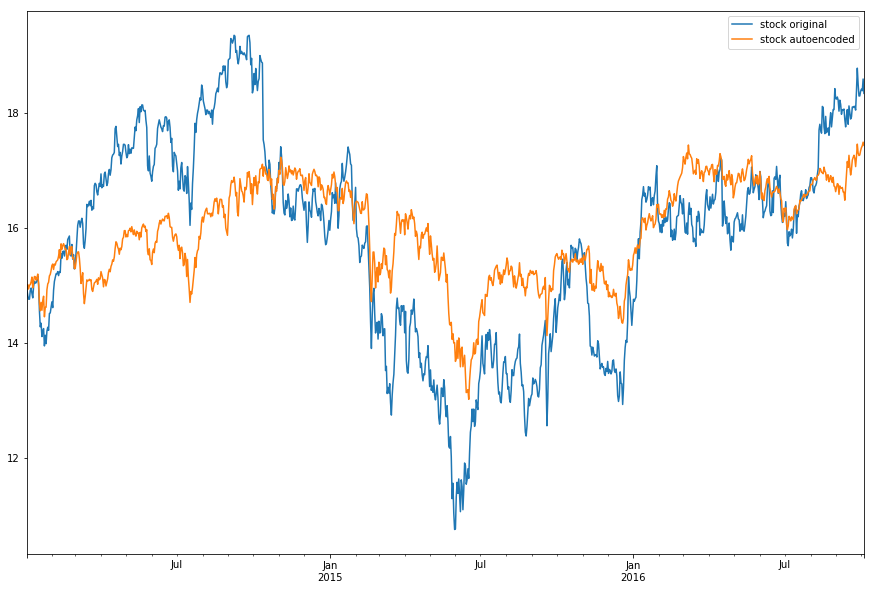

In [6]:
which_stock = 256

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].values, index=pd.date_range(start='2014/1/2', periods=1007, freq='d')).plot(figsize=(15,10),label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='stock autoencoded', legend=True)

Let's have a look on how well this auto-encoder works on a certain stock.

# Phase 2: Calibrating

In [7]:
np.concatenate((ranking[0:10], ranking[-25:])) 

array([239, 228, 275, 256, 264, 229, 124,  56,  10,   9, 110,  53, 116,
        13, 166, 148,  88,  25,  80, 245, 259,  95, 186,  61, 158, 282,
       238,  43, 224, 247, 159, 164, 253, 179, 237], dtype=int64)

In [8]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,)) # [bs, #stocks]
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img) # [bs, #neurons]
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # [bs, 1]
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler() # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=5000, batch_size = 40)    # fit the model
    deep_learner.save('model/retrack_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))


Epoch 1/5000
1007/1007 [==============================] - 0s 149us/step - loss: 1.4773
Epoch 2/5000
1007/1007 [==============================] - 0s 22us/step - loss: 1.0636
Epoch 3/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.9501
Epoch 4/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.8884
Epoch 5/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.8483
Epoch 6/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.8189
Epoch 7/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7957
Epoch 8/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.7765
Epoch 9/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7599
Epoch 10/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.7452
Epoch 11/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7318
Epoch 12/5000
1007/1007 [==========================

Epoch 95/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.2972
Epoch 96/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2943
Epoch 97/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2915
Epoch 98/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2888
Epoch 99/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2860
Epoch 100/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2833
Epoch 101/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.2806
Epoch 102/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.2780
Epoch 103/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.2753
Epoch 104/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.2727
Epoch 105/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2702
Epoch 106/5000
1007/1007 [===========

1007/1007 [==============================] - 0s 19us/step - loss: 0.1308
Epoch 188/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1297
Epoch 189/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1287
Epoch 190/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1277
Epoch 191/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.1266
Epoch 192/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1256
Epoch 193/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1246
Epoch 194/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1237
Epoch 195/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1227
Epoch 196/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1217
Epoch 197/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1207
Epoch 198/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0689
Epoch 281/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0686
Epoch 282/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0682
Epoch 283/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0678
Epoch 284/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0674
Epoch 285/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0671
Epoch 286/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0667
Epoch 287/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0664
Epoch 288/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0660
Epoch 289/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0657
Epoch 290/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0653
Epoch 291/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 17us/step - loss: 0.0466
Epoch 374/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0464
Epoch 375/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0463
Epoch 376/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0462
Epoch 377/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0460
Epoch 378/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0459
Epoch 379/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0458
Epoch 380/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0456
Epoch 381/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0455
Epoch 382/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0454
Epoch 383/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0452
Epoch 384/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 18us/step - loss: 0.0383
Epoch 467/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0383
Epoch 468/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0382
Epoch 469/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0382
Epoch 470/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0381
Epoch 471/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0381
Epoch 472/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0380
Epoch 473/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0380
Epoch 474/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0379
Epoch 475/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0379
Epoch 476/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0378
Epoch 477/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 18us/step - loss: 0.0352
Epoch 560/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0352
Epoch 561/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0351
Epoch 562/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0351
Epoch 563/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0351
Epoch 564/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0351
Epoch 565/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0351
Epoch 566/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0350
Epoch 567/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0350
Epoch 568/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0350
Epoch 569/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0350
Epoch 570/5000
1007/1007 [=====================

Epoch 652/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0338
Epoch 653/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0338
Epoch 654/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0338
Epoch 655/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0338
Epoch 656/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0338
Epoch 657/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0338
Epoch 658/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0338
Epoch 659/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0338
Epoch 660/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0338
Epoch 661/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0338
Epoch 662/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0338
Epoch 663/5000
1007/1007 [======

1007/1007 [==============================] - 0s 19us/step - loss: 0.0332
Epoch 746/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0332
Epoch 747/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0332
Epoch 748/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0331
Epoch 749/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0331
Epoch 750/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0331
Epoch 751/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0331
Epoch 752/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0331
Epoch 753/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0331
Epoch 754/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0331
Epoch 755/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.033 - 0s 20us/step - loss: 0.0331
Epoch 756/5000
1007/100

Epoch 838/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0327
Epoch 839/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0327
Epoch 840/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 841/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 842/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 843/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 844/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 845/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0327
Epoch 846/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0327
Epoch 847/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0327
Epoch 848/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0327
Epoch 849/5000
1007/1007 [======

1007/1007 [==============================] - 0s 20us/step - loss: 0.0325
Epoch 932/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0325
Epoch 933/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0325
Epoch 934/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0325
Epoch 935/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0325
Epoch 936/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 937/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0324
Epoch 938/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0324
Epoch 939/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 940/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 941/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0324
Epoch 942/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1024/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1025/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1026/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0322
Epoch 1027/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1028/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1029/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0322
Epoch 1030/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1031/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1032/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0322
Epoch 1033/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0322
Epoch 1034/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0321
Epoch 1116/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1117/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1118/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1119/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1120/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1121/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1122/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0321
Epoch 1123/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1124/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0321
Epoch 1125/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0321
Epoch 1126/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0320
Epoch 1207/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1208/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0319
Epoch 1209/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0320
Epoch 1210/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0319
Epoch 1211/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1212/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1213/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1214/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1215/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1216/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1217/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1299/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0319
Epoch 1300/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0319
Epoch 1301/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0319
Epoch 1302/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1303/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1304/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0319
Epoch 1305/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1306/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1307/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0318
Epoch 1308/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0318
Epoch 1309/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1391/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0318
Epoch 1392/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1393/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1394/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0318
Epoch 1395/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1396/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1397/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1398/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0318
Epoch 1399/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0318
Epoch 1400/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1401/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1483/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1484/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0317
Epoch 1485/5000
1007/1007 [==============================] - 0s 14us/step - loss: 0.0317
Epoch 1486/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0317
Epoch 1487/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1488/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0317
Epoch 1489/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1490/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1491/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1492/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0317
Epoch 1493/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1575/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1576/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1577/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1578/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1579/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1580/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0316
Epoch 1581/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1582/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1583/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1584/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1585/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1667/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1668/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1669/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1670/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1671/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1672/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1673/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1674/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1675/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0316
Epoch 1676/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0316
Epoch 1677/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1759/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1760/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1761/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1762/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1763/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1764/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1765/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1766/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1767/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1768/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1769/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1851/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1852/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1853/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1854/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1855/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1856/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1857/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1858/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1859/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1860/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1861/5000
1007/1007 [==========

Epoch 1942/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1943/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1944/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1945/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1946/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1947/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1948/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1949/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1950/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1951/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0315
Epoch 1952/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0315
Epoch 1953/5000
1007/

1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2034/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2035/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2036/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2037/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2038/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2039/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2040/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2041/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0314
Epoch 2042/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2043/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2044/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2125/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2126/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2127/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2128/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2129/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2130/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2131/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2132/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2133/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2134/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0314
Epoch 2135/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2217/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2218/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0314
Epoch 2219/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2220/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0314
Epoch 2221/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2222/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2223/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0314
Epoch 2224/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0314
Epoch 2225/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0314
Epoch 2226/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0314
Epoch 2227/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2309/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2310/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2311/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2312/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2313/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2314/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2315/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2316/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2317/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2318/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2319/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 19us/step - loss: 0.0313
Epoch 2400/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0313
Epoch 2401/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2402/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0313
Epoch 2403/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2404/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0313
Epoch 2405/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2406/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2407/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2408/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2409/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2410/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2492/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2493/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2494/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2495/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2496/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2497/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2498/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2499/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2500/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2501/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2502/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2584/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2585/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2586/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2587/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2588/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2589/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2590/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2591/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2592/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2593/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2594/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2676/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0313
Epoch 2677/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2678/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2679/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0313
Epoch 2680/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2681/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2682/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2683/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0313
Epoch 2684/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2685/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0313
Epoch 2686/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2768/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2769/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2770/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2771/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2772/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0313
Epoch 2773/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2774/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2775/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2776/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2777/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 2778/5000
1007/1007 [==========

Epoch 2859/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2860/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2861/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 2862/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2863/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2864/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2865/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2866/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2867/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2868/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2869/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 2870/5000
1007/

1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2951/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2952/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2953/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2954/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2955/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2956/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2957/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2958/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2959/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 2960/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 2961/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0312
Epoch 3043/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0312
Epoch 3044/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0312
Epoch 3045/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0312
Epoch 3046/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0312
Epoch 3047/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3048/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3049/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3050/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3051/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3052/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3053/5000
1007/1007 [==========

Epoch 3134/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 3135/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3136/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 3137/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3138/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0312
Epoch 3139/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0312
Epoch 3140/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0312
Epoch 3141/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3142/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3143/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3144/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3145/5000
1007/

1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3227/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3228/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3229/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3230/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3231/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3232/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3233/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3234/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3235/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0312
Epoch 3236/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3237/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3319/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3320/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3321/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3322/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3323/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3324/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3325/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3326/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3327/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3328/5000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0312
Epoch 3329/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3411/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0312
Epoch 3412/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0312
Epoch 3413/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3414/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3415/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0312
Epoch 3416/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3417/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3418/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3419/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3420/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3421/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3503/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3504/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0312
Epoch 3505/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0312
Epoch 3506/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3507/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0312
Epoch 3508/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0312
Epoch 3509/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3510/5000
1007/1007 [==============================] - 0s 15us/step - loss: 0.0312
Epoch 3511/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0312
Epoch 3512/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0312
Epoch 3513/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3595/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0311
Epoch 3596/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3597/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3598/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3599/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3600/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3601/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0311
Epoch 3602/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 3603/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 3604/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0311
Epoch 3605/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 3687/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3688/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 3689/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3690/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3691/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3692/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3693/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3694/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3695/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3696/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3697/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3779/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3780/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3781/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3782/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3783/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3784/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3785/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3786/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3787/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3788/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3789/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3871/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3872/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3873/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3874/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3875/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3876/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3877/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3878/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3879/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0311
Epoch 3880/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3881/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3963/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 3964/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3965/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3966/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3967/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3968/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3969/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3970/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 3971/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 3972/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 3973/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4055/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4056/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0311
Epoch 4057/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4058/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4059/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4060/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4061/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4062/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4063/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4064/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4065/5000
1007/1007 [==========

Epoch 4146/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4147/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4148/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4149/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4150/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4151/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4152/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4153/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4154/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4155/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4156/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4157/5000
1007/

1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4239/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4240/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4241/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4242/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4243/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4244/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4245/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4246/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4247/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0311
Epoch 4248/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4249/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4331/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4332/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 4333/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4334/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4335/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4336/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4337/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0311
Epoch 4338/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4339/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4340/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4341/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4423/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0311
Epoch 4424/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4425/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4426/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4427/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4428/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4429/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4430/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4431/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0311
Epoch 4432/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4433/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4515/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4516/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4517/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4518/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4519/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4520/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4521/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4522/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4523/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4524/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4525/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4607/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4608/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4609/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4610/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4611/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4612/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0311
Epoch 4613/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0311
Epoch 4614/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4615/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0311
Epoch 4616/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0311
Epoch 4617/5000
1007/1007 [==========

Epoch 4698/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4699/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4700/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4701/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4702/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4703/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4704/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4705/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4706/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4707/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4708/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4709/5000
1007/

1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4790/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4791/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4792/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4793/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4794/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4795/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0310
Epoch 4796/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4797/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4798/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4799/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4800/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4881/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4882/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4883/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4884/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.030 - 0s 17us/step - loss: 0.0310
Epoch 4885/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4886/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4887/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0310
Epoch 4888/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4889/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4890/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4891/50

Epoch 4972/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4973/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4974/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0310
Epoch 4975/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4976/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4977/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0310
Epoch 4978/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0310
Epoch 4979/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0310
Epoch 4980/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0310
Epoch 4981/5000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0310
Epoch 4982/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0310
Epoch 4983/5000
1007/

1007/1007 [==============================] - 0s 23us/step - loss: 0.4922
Epoch 66/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.4872
Epoch 67/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.4822
Epoch 68/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.4773
Epoch 69/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.4725
Epoch 70/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.4677
Epoch 71/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.4630
Epoch 72/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.4583
Epoch 73/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.4536
Epoch 74/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.4490
Epoch 75/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.4445
Epoch 76/5000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 23us/step - loss: 0.1949
Epoch 159/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1931
Epoch 160/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1912
Epoch 161/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1894
Epoch 162/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1876
Epoch 163/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.1858
Epoch 164/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.187 - 0s 23us/step - loss: 0.1840
Epoch 165/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.1823
Epoch 166/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1805
Epoch 167/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1788
Epoch 168/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1771
Epoch 169/5000
1007/100

Epoch 251/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0838
Epoch 252/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0831
Epoch 253/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0825
Epoch 254/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0818
Epoch 255/5000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0811
Epoch 256/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0804
Epoch 257/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0798
Epoch 258/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0791
Epoch 259/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0785
Epoch 260/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0778
Epoch 261/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0772
Epoch 262/5000
1007/1007 [======

Epoch 344/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0426
Epoch 345/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0423
Epoch 346/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.042 - 0s 23us/step - loss: 0.0421
Epoch 347/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0418
Epoch 348/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0416
Epoch 349/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0413
Epoch 350/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0411
Epoch 351/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0408
Epoch 352/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0406
Epoch 353/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0404
Epoch 354/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0401
Epoch 35

1007/1007 [==============================] - 0s 22us/step - loss: 0.0274
Epoch 437/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0273
Epoch 438/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0272
Epoch 439/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0271
Epoch 440/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0270
Epoch 441/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0269
Epoch 442/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0269
Epoch 443/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0268
Epoch 444/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0267
Epoch 445/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0266
Epoch 446/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0265
Epoch 447/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0217
Epoch 529/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0216
Epoch 530/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0216
Epoch 531/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0216
Epoch 532/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0215
Epoch 533/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0215
Epoch 534/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0215
Epoch 535/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0214
Epoch 536/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0214
Epoch 537/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0213
Epoch 538/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0213
Epoch 539/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 21us/step - loss: 0.0194
Epoch 622/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0194
Epoch 623/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0194
Epoch 624/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0194
Epoch 625/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0193
Epoch 626/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0193
Epoch 627/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0193
Epoch 628/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0193
Epoch 629/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0193
Epoch 630/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0193
Epoch 631/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0193
Epoch 632/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 20us/step - loss: 0.0185
Epoch 715/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0184
Epoch 716/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0184
Epoch 717/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0184
Epoch 718/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0184
Epoch 719/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0184
Epoch 720/5000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0184
Epoch 721/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0184
Epoch 722/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0184
Epoch 723/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0184
Epoch 724/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0184
Epoch 725/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0180
Epoch 808/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0180
Epoch 809/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0180
Epoch 810/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0180
Epoch 811/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0180
Epoch 812/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0180
Epoch 813/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0180
Epoch 814/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0180
Epoch 815/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0180
Epoch 816/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0180
Epoch 817/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0180
Epoch 818/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 27us/step - loss: 0.0178
Epoch 901/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0178
Epoch 902/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0178
Epoch 903/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0178
Epoch 904/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0178
Epoch 905/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0178
Epoch 906/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0178
Epoch 907/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0178
Epoch 908/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0178
Epoch 909/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0178
Epoch 910/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0178
Epoch 911/5000
1007/1007 [=====================

Epoch 993/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0176
Epoch 994/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0176
Epoch 995/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0176
Epoch 996/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0176
Epoch 997/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0176
Epoch 998/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0176
Epoch 999/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0176
Epoch 1000/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0176
Epoch 1001/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0176
Epoch 1002/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0176
Epoch 1003/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0176
Epoch 1004/5000
1007/1007 [=

1007/1007 [==============================] - 0s 23us/step - loss: 0.0175
Epoch 1085/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0175
Epoch 1086/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0175
Epoch 1087/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0175
Epoch 1088/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0175
Epoch 1089/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0175
Epoch 1090/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0175
Epoch 1091/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0175
Epoch 1092/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0175
Epoch 1093/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0175
Epoch 1094/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0175
Epoch 1095/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1177/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1178/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0174
Epoch 1179/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0174
Epoch 1180/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1181/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0174
Epoch 1182/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1183/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0174
Epoch 1184/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0174
Epoch 1185/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0174
Epoch 1186/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0174
Epoch 1187/5000
1007/1007 [==========

Epoch 1268/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1269/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1270/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1271/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1272/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1273/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1274/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1275/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0174
Epoch 1276/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1277/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0174
Epoch 1278/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0174
Epoch 1279/5000
1007/

1007/1007 [==============================] - 0s 22us/step - loss: 0.0173
Epoch 1361/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0173
Epoch 1362/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1363/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0173
Epoch 1364/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1365/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1366/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0173
Epoch 1367/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 1368/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0173
Epoch 1369/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0173
Epoch 1370/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1371/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1453/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0173
Epoch 1454/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 1455/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0173
Epoch 1456/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0173
Epoch 1457/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0173
Epoch 1458/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0173
Epoch 1459/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0173
Epoch 1460/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0173
Epoch 1461/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0173
Epoch 1462/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0173
Epoch 1463/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0173
Epoch 1545/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0173
Epoch 1546/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.017 - 0s 20us/step - loss: 0.0173
Epoch 1547/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0173
Epoch 1548/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.017 - 0s 22us/step - loss: 0.0173
Epoch 1549/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0173
Epoch 1550/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0173
Epoch 1551/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0173
Epoch 1552/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0173
Epoch 1553/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0173
Epoch 1554/5000
1007/1007 [==============================] - 0s 24us/step - lo

1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1636/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1637/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0172
Epoch 1638/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1639/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1640/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1641/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1642/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0172
Epoch 1643/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1644/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1645/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1646/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1728/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1729/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1730/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1731/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1732/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1733/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1734/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1735/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1736/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1737/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1738/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1820/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1821/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1822/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1823/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1824/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1825/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1826/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1827/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0172
Epoch 1828/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0172
Epoch 1829/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1830/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0172
Epoch 1912/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1913/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0172
Epoch 1914/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1915/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0172
Epoch 1916/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1917/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1918/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0172
Epoch 1919/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.017 - 0s 20us/step - loss: 0.0172
Epoch 1920/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1921/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0172
Epoch 1922/50

Epoch 2003/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2004/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2005/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2006/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2007/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2008/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2009/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2010/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2011/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2012/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2013/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0171
Epoch 2014/5000
1007/

1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2096/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2097/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2098/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2099/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2100/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2101/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2102/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2103/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2104/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2105/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2106/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2187/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2188/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2189/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2190/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2191/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2192/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2193/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2194/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2195/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2196/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0171
Epoch 2197/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2279/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2280/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2281/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2282/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2283/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0171
Epoch 2284/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2285/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2286/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2287/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2288/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0171
Epoch 2289/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2371/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2372/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2373/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2374/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2375/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2376/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2377/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2378/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2379/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2380/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2381/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2463/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0171
Epoch 2464/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2465/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2466/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2467/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2468/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2469/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2470/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2471/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2472/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2473/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0171
Epoch 2555/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2556/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2557/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2558/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2559/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0171
Epoch 2560/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2561/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2562/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0171
Epoch 2563/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2564/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0171
Epoch 2565/5000
1007/1007 [==========

Epoch 2646/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 2647/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 2648/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2649/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2650/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2651/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2652/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2653/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2654/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2655/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2656/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2657/5000
1007/

1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2739/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 2740/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2741/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 2742/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2743/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2744/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2745/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2746/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 2747/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2748/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2749/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2831/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 2832/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2833/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2834/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 2835/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2836/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2837/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2838/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2839/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 2840/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2841/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2923/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2924/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2925/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 2926/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2927/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 2928/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2929/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0170
Epoch 2930/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2931/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 2932/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 2933/5000
1007/1007 [==========

Epoch 3014/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3015/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3016/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3017/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3018/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3019/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3020/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3021/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3022/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3023/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3024/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3025/5000
1007/

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3107/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3108/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3109/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3110/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3111/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3112/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3113/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3114/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3115/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3116/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3117/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3199/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3200/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3201/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3202/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3203/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3204/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3205/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3206/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3207/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3208/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3209/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3291/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3292/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3293/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3294/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3295/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3296/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3297/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3298/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3299/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3300/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3301/5000
1007/1007 [==========

Epoch 3382/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3383/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3384/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3385/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3386/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3387/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3388/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3389/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3390/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3391/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3392/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3393/5000
1007/

1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3474/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3475/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3476/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3477/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3478/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3479/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3480/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3481/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3482/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3483/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3484/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3566/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3567/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3568/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3569/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3570/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3571/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3572/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3573/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3574/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3575/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3576/5000
1007/1007 [==========

Epoch 3657/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3658/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3659/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3660/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3661/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0170
Epoch 3662/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3663/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3664/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3665/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3666/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3667/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0170
Epoch 3668/5000
1007/

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3749/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3750/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3751/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3752/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3753/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3754/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3755/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3756/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3757/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3758/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3759/5000
1007/1007 [==========

Epoch 3840/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0170
Epoch 3841/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3842/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3843/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0170
Epoch 3844/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0170
Epoch 3845/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0170
Epoch 3846/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3847/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3848/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.017 - 0s 20us/step - loss: 0.0170
Epoch 3849/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3850/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.01

1007/1007 [==============================] - 0s 21us/step - loss: 0.0170
Epoch 3932/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3933/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3934/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3935/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 3936/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3937/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3938/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0170
Epoch 3939/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0170
Epoch 3940/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 3941/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 3942/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4024/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0169
Epoch 4025/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4026/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4027/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4028/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4029/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4030/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4031/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4032/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4033/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4034/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4116/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4117/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4118/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4119/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4120/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4121/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4122/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4123/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4124/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4125/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4126/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4208/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4209/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4210/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4211/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4212/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4213/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4214/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4215/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4216/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4217/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4218/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4300/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4301/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4302/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4303/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4304/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4305/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4306/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4307/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4308/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4309/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4310/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 29us/step - loss: 0.0169
Epoch 4392/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4393/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4394/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4395/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4396/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4397/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4398/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4399/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4400/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4401/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4402/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4484/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4485/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4486/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4487/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4488/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4489/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4490/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4491/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4492/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4493/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4494/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4576/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4577/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0169
Epoch 4578/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0169
Epoch 4579/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4580/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4581/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4582/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4583/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4584/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4585/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4586/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4668/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4669/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4670/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4671/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4672/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4673/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4674/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4675/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4676/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4677/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.017 - 0s 21us/step - loss: 0.0169
Epoch 4678/50

Epoch 4759/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4760/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4761/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4762/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4763/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4764/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4765/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4766/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4767/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4768/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0169
Epoch 4769/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0169
Epoch 4770/5000
1007/

1007/1007 [==============================] - 0s 24us/step - loss: 0.0169
Epoch 4852/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0169
Epoch 4853/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4854/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0169
Epoch 4855/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4856/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4857/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4858/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4859/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4860/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4861/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4862/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4944/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4945/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0169
Epoch 4946/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4947/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4948/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4949/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0169
Epoch 4950/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0169
Epoch 4951/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4952/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0169
Epoch 4953/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0169
Epoch 4954/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.7239
Epoch 37/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.7163
Epoch 38/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.7088
Epoch 39/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7014
Epoch 40/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.6940
Epoch 41/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.6868
Epoch 42/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.6796
Epoch 43/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.6725
Epoch 44/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.6655
Epoch 45/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.6586
Epoch 46/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.6517
Epoch 47/5000
1007/1007 [==============================] 

Epoch 130/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.2763
Epoch 131/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.2735
Epoch 132/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.2708
Epoch 133/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.2681
Epoch 134/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2654
Epoch 135/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.2628
Epoch 136/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.2602
Epoch 137/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.2576
Epoch 138/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.2550
Epoch 139/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.2525
Epoch 140/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.2500
Epoch 141/5000
1007/1007 [======

1007/1007 [==============================] - 0s 32us/step - loss: 0.1123
Epoch 224/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.1112
Epoch 225/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.1102
Epoch 226/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.1092
Epoch 227/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.1082
Epoch 228/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.1072
Epoch 229/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.1062
Epoch 230/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.1053
Epoch 231/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.1043
Epoch 232/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1034
Epoch 233/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.1024
Epoch 234/5000
1007/1007 [=====================

Epoch 316/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0507
Epoch 317/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0503
Epoch 318/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0500
Epoch 319/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0496
Epoch 320/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0492
Epoch 321/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0488
Epoch 322/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0485
Epoch 323/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0481
Epoch 324/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0477
Epoch 325/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0474
Epoch 326/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0470
Epoch 327/5000
1007/1007 [======

1007/1007 [==============================] - 0s 23us/step - loss: 0.0276
Epoch 410/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0275
Epoch 411/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0273
Epoch 412/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0272
Epoch 413/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0270
Epoch 414/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0269
Epoch 415/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0268
Epoch 416/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0266
Epoch 417/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0265
Epoch 418/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0264
Epoch 419/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0262
Epoch 420/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0189
Epoch 503/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0189
Epoch 504/5000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0188
Epoch 505/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0188
Epoch 506/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0187
Epoch 507/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0187
Epoch 508/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0186
Epoch 509/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0185
Epoch 510/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0185
Epoch 511/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0184
Epoch 512/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0184
Epoch 513/5000
1007/1007 [=====================

Epoch 595/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0156
Epoch 596/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0156
Epoch 597/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0155
Epoch 598/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0155
Epoch 599/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0155
Epoch 600/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0155
Epoch 601/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0155
Epoch 602/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0154
Epoch 603/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0154
Epoch 604/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0154
Epoch 605/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0154
Epoch 606/5000
1007/1007 [======

1007/1007 [==============================] - 0s 24us/step - loss: 0.0142
Epoch 688/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0142
Epoch 689/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0142
Epoch 690/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0142
Epoch 691/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0142
Epoch 692/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0142
Epoch 693/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0142
Epoch 694/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0142
Epoch 695/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0142
Epoch 696/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0142
Epoch 697/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0142
Epoch 698/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0136
Epoch 780/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0136
Epoch 781/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0136
Epoch 782/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0136
Epoch 783/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0136
Epoch 784/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0136
Epoch 785/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0136
Epoch 786/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0136
Epoch 787/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0136
Epoch 788/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0136
Epoch 789/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0136
Epoch 790/5000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0134
Epoch 873/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0134
Epoch 874/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0134
Epoch 875/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0134
Epoch 876/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0134
Epoch 877/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0134
Epoch 878/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0134
Epoch 879/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0133
Epoch 880/5000
1007/1007 [==============================] - ETA: 0s - loss: 0.014 - 0s 28us/step - loss: 0.0133
Epoch 881/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0133
Epoch 882/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0133
Epoch 883/5000
1007/100

Epoch 965/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 966/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0132
Epoch 967/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0132
Epoch 968/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0132
Epoch 969/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 970/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0132
Epoch 971/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 972/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0132
Epoch 973/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0132
Epoch 974/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0132
Epoch 975/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 976/5000
1007/1007 [======

1007/1007 [==============================] - 0s 24us/step - loss: 0.0131
Epoch 1058/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0131
Epoch 1059/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0131
Epoch 1060/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0131
Epoch 1061/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0131
Epoch 1062/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0131
Epoch 1063/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0131
Epoch 1064/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0131
Epoch 1065/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0131
Epoch 1066/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0131
Epoch 1067/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0131
Epoch 1068/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0131
Epoch 1150/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1151/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1152/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1153/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0130
Epoch 1154/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0130
Epoch 1155/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0130
Epoch 1156/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1157/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0130
Epoch 1158/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1159/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0130
Epoch 1160/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0130
Epoch 1242/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1243/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1244/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1245/5000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0130
Epoch 1246/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0130
Epoch 1247/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0130
Epoch 1248/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0130
Epoch 1249/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0130
Epoch 1250/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1251/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0130
Epoch 1252/5000
1007/1007 [==========

Epoch 1333/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1334/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0130
Epoch 1335/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1336/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0130
Epoch 1337/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1338/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0130
Epoch 1339/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0130
Epoch 1340/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0130
Epoch 1341/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0130
Epoch 1342/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0130
Epoch 1343/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0130
Epoch 1344/5000
1007/

1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1426/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1427/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0129
Epoch 1428/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1429/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0129
Epoch 1430/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0129
Epoch 1431/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0129
Epoch 1432/5000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0129
Epoch 1433/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0129
Epoch 1434/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1435/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1436/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 28us/step - loss: 0.0129
Epoch 1518/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1519/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0129
Epoch 1520/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1521/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1522/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1523/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0129
Epoch 1524/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0129
Epoch 1525/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0129
Epoch 1526/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1527/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1528/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1610/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0129
Epoch 1611/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0129
Epoch 1612/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1613/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1614/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1615/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1616/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1617/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1618/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0129
Epoch 1619/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1620/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 21us/step - loss: 0.0129
Epoch 1702/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0129
Epoch 1703/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1704/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0129
Epoch 1705/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1706/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1707/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1708/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1709/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1710/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0129
Epoch 1711/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0129
Epoch 1712/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1794/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1795/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1796/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1797/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1798/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1799/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 1800/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1801/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1802/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0128
Epoch 1803/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1804/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1886/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1887/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1888/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0128
Epoch 1889/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1890/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1891/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1892/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 1893/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1894/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 1895/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1896/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 1977/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 1978/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0128
Epoch 1979/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0128
Epoch 1980/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 1981/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 1982/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1983/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 1984/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1985/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1986/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 1987/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2069/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2070/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2071/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2072/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2073/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0128
Epoch 2074/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 2075/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 2076/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2077/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 2078/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 2079/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2161/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2162/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2163/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2164/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2165/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2166/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2167/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0128
Epoch 2168/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0128
Epoch 2169/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0128
Epoch 2170/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2171/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2253/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2254/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2255/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2256/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2257/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 2258/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2259/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2260/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0128
Epoch 2261/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2262/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2263/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2345/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2346/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0128
Epoch 2347/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2348/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2349/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0128
Epoch 2350/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2351/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2352/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0128
Epoch 2353/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2354/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2355/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2437/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2438/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2439/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0128
Epoch 2440/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2441/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0128
Epoch 2442/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2443/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2444/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2445/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0128
Epoch 2446/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0128
Epoch 2447/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 2529/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2530/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2531/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2532/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2533/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2534/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2535/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2536/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2537/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2538/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2539/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 2621/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2622/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2623/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2624/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0127
Epoch 2625/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2626/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 2627/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2628/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2629/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2630/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2631/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2713/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2714/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2715/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 2716/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2717/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2718/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2719/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2720/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2721/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2722/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2723/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 2805/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2806/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2807/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2808/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2809/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2810/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2811/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2812/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 2813/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2814/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2815/5000
1007/1007 [==========

Epoch 2896/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2897/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 2898/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2899/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 2900/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2901/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2902/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2903/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2904/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2905/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 2906/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2907/5000
1007/

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2989/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 2990/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0127
Epoch 2991/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2992/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 2993/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2994/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2995/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 2996/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 2997/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 2998/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 2999/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3081/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3082/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3083/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3084/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 3085/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3086/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3087/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3088/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3089/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3090/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3091/5000
1007/1007 [==========

Epoch 3172/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3173/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3174/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3175/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 3176/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3177/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3178/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3179/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3180/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 3181/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3182/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3183/5000
1007/

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3264/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3265/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3266/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 3267/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3268/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3269/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3270/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3271/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3272/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3273/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3274/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3356/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3357/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3358/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3359/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3360/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3361/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 3362/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3363/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3364/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3365/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 3366/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3448/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3449/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3450/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3451/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 3452/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3453/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3454/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3455/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3456/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3457/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3458/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3540/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3541/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3542/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3543/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3544/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3545/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 3546/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3547/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3548/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3549/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3550/5000
1007/1007 [==========

Epoch 3631/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3632/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3633/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0127
Epoch 3634/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3635/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3636/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3637/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3638/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3639/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3640/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3641/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3642/5000
1007/

1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3724/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3725/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3726/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3727/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3728/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 3729/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3730/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3731/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3732/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 3733/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3734/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 32us/step - loss: 0.0127
Epoch 3816/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0127
Epoch 3817/5000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0127
Epoch 3818/5000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0127
Epoch 3819/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3820/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3821/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3822/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3823/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 3824/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3825/5000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0127
Epoch 3826/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3908/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 3909/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0127
Epoch 3910/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3911/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 3912/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3913/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3914/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3915/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3916/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 3917/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 3918/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4000/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4001/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 4002/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4003/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4004/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4005/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4006/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4007/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4008/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4009/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4010/5000
1007/1007 [==========

Epoch 4091/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4092/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4093/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4094/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4095/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4096/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4097/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4098/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4099/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4100/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4101/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4102/5000
1007/

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4184/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4185/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4186/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4187/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4188/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4189/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4190/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4191/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4192/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4193/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4194/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4276/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4277/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4278/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4279/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4280/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 4281/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4282/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4283/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4284/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4285/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4286/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4368/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4369/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4370/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4371/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4372/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4373/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 4374/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4375/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4376/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4377/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4378/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4460/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4461/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4462/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4463/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4464/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4465/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4466/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4467/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4468/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4469/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4470/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4552/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4553/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4554/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4555/5000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0127
Epoch 4556/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4557/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4558/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4559/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4560/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4561/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4562/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4644/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4645/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4646/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4647/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4648/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4649/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4650/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4651/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4652/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4653/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4654/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4736/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4737/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4738/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4739/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4740/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4741/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4742/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4743/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4744/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4745/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4746/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4828/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4829/5000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0127
Epoch 4830/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4831/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4832/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4833/5000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0127
Epoch 4834/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4835/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4836/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4837/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4838/5000
1007/1007 [==========

1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4920/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4921/5000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0127
Epoch 4922/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4923/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4924/5000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0127
Epoch 4925/5000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0127
Epoch 4926/5000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0127
Epoch 4927/5000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0127
Epoch 4928/5000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0127
Epoch 4929/5000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0127
Epoch 4930/5000
1007/1007 [==========

Now we would like to see how similar these 3 portfolios perform as the original IBB Index does on training dates.

S90 2-norm difference:  156.693
S180 2-norm difference:  29.2943
S270 2-norm difference:  37.0102


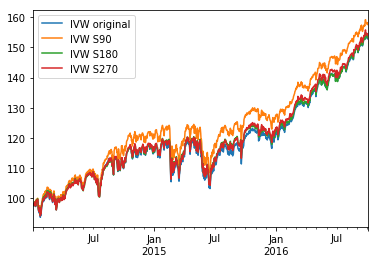

In [9]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='IVW original', legend=True)

for s in [90, 180, 270]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='2014/1/2', periods = 1007,freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])    

# Phase 3: Validating

In [10]:
for lam in [0.01, 0.05, 0.1]:
    ibb_predict = defaultdict(defaultdict)
    total_2_norm_diff = defaultdict(defaultdict)
    dl_scaler = defaultdict(StandardScaler)
    
    for non_communal in [70, 160, 250]:  
        # some numerical values
        encoding_dim = 64
        s = 20 + non_communal
        stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
        
        
        # connect all layers
        input_img = Input(shape=(s,))
        encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(lam))(input_img)
        decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(lam))(encoded)
        
        
        # construct and compile deep learning routine
        deep_learner = Model(input_img, decoded)
        deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
        
        x = stock['calibrate']['percentage'].iloc[:, stock_index]
        y = ibb['calibrate']['percentage']
        
        dl_scaler[s] = StandardScaler() # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
        dl_scaler[s].fit(x)
        x = dl_scaler[s].transform(x)  
        
        deep_learner.fit(x, y, shuffle=False, epochs=1000, batch_size = 40)    # fit the model
        deep_learner.save('model/retrack_s' + str(s) + 'lambda_' + str(lam) + '.h5') # for validation phase use

Epoch 1/1000
1007/1007 [==============================] - 0s 191us/step - loss: 1.1981
Epoch 2/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.9784
Epoch 3/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.9023
Epoch 4/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.8576
Epoch 5/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.8265
Epoch 6/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.8027
Epoch 7/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.7832
Epoch 8/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7665
Epoch 9/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7519
Epoch 10/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.7387
Epoch 11/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.7265
Epoch 12/1000
1007/1007 [==========================

Epoch 95/1000
1007/1007 [==============================] - 0s 16us/step - loss: 0.3004
Epoch 96/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2975
Epoch 97/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2947
Epoch 98/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2919
Epoch 99/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.2891
Epoch 100/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.2864
Epoch 101/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2837
Epoch 102/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.2810
Epoch 103/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2783
Epoch 104/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2757
Epoch 105/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2731
Epoch 106/1000
1007/1007 [===========

1007/1007 [==============================] - 0s 19us/step - loss: 0.1310
Epoch 189/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1299
Epoch 190/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1289
Epoch 191/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1279
Epoch 192/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1268
Epoch 193/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1258
Epoch 194/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1248
Epoch 195/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1238
Epoch 196/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1229
Epoch 197/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1219
Epoch 198/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1209
Epoch 199/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 20us/step - loss: 0.0689
Epoch 282/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0685
Epoch 283/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0681
Epoch 284/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0677
Epoch 285/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0674
Epoch 286/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0670
Epoch 287/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0666
Epoch 288/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0663
Epoch 289/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0659
Epoch 290/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0656
Epoch 291/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0652
Epoch 292/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 17us/step - loss: 0.0464
Epoch 375/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0463
Epoch 376/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0462
Epoch 377/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0460
Epoch 378/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0459
Epoch 379/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0458
Epoch 380/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0456
Epoch 381/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0455
Epoch 382/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0454
Epoch 383/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0452
Epoch 384/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0451
Epoch 385/1000
1007/1007 [=====================

Epoch 467/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0382
Epoch 468/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0382
Epoch 469/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0381
Epoch 470/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0381
Epoch 471/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0380
Epoch 472/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0380
Epoch 473/1000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0379
Epoch 474/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0379
Epoch 475/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0378
Epoch 476/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0378
Epoch 477/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0377
Epoch 478/1000
1007/1007 [======

1007/1007 [==============================] - 0s 19us/step - loss: 0.0351
Epoch 560/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0351
Epoch 561/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0350
Epoch 562/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0350
Epoch 563/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0350
Epoch 564/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0350
Epoch 565/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0349
Epoch 566/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0349
Epoch 567/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0349
Epoch 568/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0349
Epoch 569/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0349
Epoch 570/1000
1007/1007 [=====================

Epoch 652/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0336
Epoch 653/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.033 - 0s 19us/step - loss: 0.0336
Epoch 654/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0336
Epoch 655/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0335
Epoch 656/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0335
Epoch 657/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0335
Epoch 658/1000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0335
Epoch 659/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0335
Epoch 660/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0335
Epoch 661/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0335
Epoch 662/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0335
Epoch 66

1007/1007 [==============================] - 0s 20us/step - loss: 0.0328
Epoch 745/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0328
Epoch 746/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0328
Epoch 747/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0328
Epoch 748/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0328
Epoch 749/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0328
Epoch 750/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0328
Epoch 751/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0328
Epoch 752/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0328
Epoch 753/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0328
Epoch 754/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0328
Epoch 755/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 19us/step - loss: 0.0324
Epoch 838/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0324
Epoch 839/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 840/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 841/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 842/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 843/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0324
Epoch 844/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0324
Epoch 845/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0324
Epoch 846/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0324
Epoch 847/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0324
Epoch 848/1000
1007/1007 [=====================

Epoch 930/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0322
Epoch 931/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0322
Epoch 932/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0322
Epoch 933/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0322
Epoch 934/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0322
Epoch 935/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0322
Epoch 936/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0322
Epoch 937/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0322
Epoch 938/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0322
Epoch 939/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0322
Epoch 940/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0322
Epoch 941/1000
1007/1007 [======

1007/1007 [==============================] - 0s 21us/step - loss: 0.7702
Epoch 23/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.7615
Epoch 24/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.7530
Epoch 25/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.7447
Epoch 26/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.7366
Epoch 27/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.7286
Epoch 28/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.7207
Epoch 29/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.7129
Epoch 30/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.7053
Epoch 31/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.6977
Epoch 32/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.6903
Epoch 33/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 22us/step - loss: 0.2954
Epoch 116/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2925
Epoch 117/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2896
Epoch 118/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2867
Epoch 119/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2839
Epoch 120/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2811
Epoch 121/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.2783
Epoch 122/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2755
Epoch 123/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.2728
Epoch 124/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.2701
Epoch 125/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.270 - 0s 22us/step - loss: 0.2675
Epoch 126/1000
1007/100

1007/1007 [==============================] - 0s 27us/step - loss: 0.1224
Epoch 208/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.1213
Epoch 209/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1202
Epoch 210/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1191
Epoch 211/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1180
Epoch 212/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1170
Epoch 213/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1159
Epoch 214/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1149
Epoch 215/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1139
Epoch 216/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.1129
Epoch 217/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1119
Epoch 218/1000
1007/1007 [=====================

Epoch 300/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0569
Epoch 301/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0565
Epoch 302/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0561
Epoch 303/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0557
Epoch 304/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0553
Epoch 305/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.055 - 0s 20us/step - loss: 0.0549
Epoch 306/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0545
Epoch 307/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0542
Epoch 308/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0538
Epoch 309/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0534
Epoch 310/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0530
Epoch 31

1007/1007 [==============================] - 0s 21us/step - loss: 0.0329
Epoch 393/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0327
Epoch 394/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0326
Epoch 395/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0324
Epoch 396/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0323
Epoch 397/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0321
Epoch 398/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0320
Epoch 399/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0318
Epoch 400/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0317
Epoch 401/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0316
Epoch 402/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0314
Epoch 403/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0238
Epoch 486/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0237
Epoch 487/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0237
Epoch 488/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0236
Epoch 489/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0236
Epoch 490/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0235
Epoch 491/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0235
Epoch 492/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0234
Epoch 493/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0234
Epoch 494/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0233
Epoch 495/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0233
Epoch 496/1000
1007/1007 [=====================

Epoch 578/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0203
Epoch 579/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0203
Epoch 580/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0203
Epoch 581/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0203
Epoch 582/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0202
Epoch 583/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0202
Epoch 584/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0202
Epoch 585/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0202
Epoch 586/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0201
Epoch 587/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0201
Epoch 588/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0201
Epoch 589/1000
1007/1007 [======

1007/1007 [==============================] - 0s 22us/step - loss: 0.0189
Epoch 671/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0189
Epoch 672/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0189
Epoch 673/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 674/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0189
Epoch 675/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0189
Epoch 676/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0188
Epoch 677/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0188
Epoch 678/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0188
Epoch 679/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0188
Epoch 680/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0188
Epoch 681/1000
1007/1007 [=====================

Epoch 763/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0183
Epoch 764/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0183
Epoch 765/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0183
Epoch 766/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0183
Epoch 767/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0183
Epoch 768/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0183
Epoch 769/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0182
Epoch 770/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0182
Epoch 771/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0182
Epoch 772/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0182
Epoch 773/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0182
Epoch 774/1000
1007/1007 [======

1007/1007 [==============================] - 0s 22us/step - loss: 0.0180
Epoch 856/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0180
Epoch 857/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0179
Epoch 858/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0179
Epoch 859/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0179
Epoch 860/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 861/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 862/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0179
Epoch 863/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0179
Epoch 864/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 865/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0179
Epoch 866/1000
1007/1007 [=====================

Epoch 948/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0178
Epoch 949/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0178
Epoch 950/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0178
Epoch 951/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0178
Epoch 952/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 953/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 954/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 955/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 956/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 957/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0178
Epoch 958/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0178
Epoch 959/1000
1007/1007 [======

1007/1007 [==============================] - 0s 25us/step - loss: 0.6946
Epoch 42/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.6874
Epoch 43/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.6802
Epoch 44/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.6731
Epoch 45/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.6661
Epoch 46/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.6591
Epoch 47/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.6523
Epoch 48/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.6455
Epoch 49/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.6388
Epoch 50/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.6322
Epoch 51/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.6256
Epoch 52/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 24us/step - loss: 0.2683
Epoch 135/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2656
Epoch 136/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.2630
Epoch 137/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.2604
Epoch 138/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.2578
Epoch 139/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.2552
Epoch 140/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.2527
Epoch 141/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.2502
Epoch 142/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.2477
Epoch 143/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.2453
Epoch 144/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.2428
Epoch 145/1000
1007/1007 [=====================

Epoch 227/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1093
Epoch 228/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.1083
Epoch 229/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1073
Epoch 230/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1063
Epoch 231/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.1053
Epoch 232/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1044
Epoch 233/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.1034
Epoch 234/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1025
Epoch 235/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1016
Epoch 236/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.1007
Epoch 237/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0997
Epoch 238/1000
1007/1007 [======

1007/1007 [==============================] - 0s 26us/step - loss: 0.0496
Epoch 321/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0493
Epoch 322/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0489
Epoch 323/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0485
Epoch 324/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0482
Epoch 325/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0478
Epoch 326/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0474
Epoch 327/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0471
Epoch 328/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0467
Epoch 329/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0464
Epoch 330/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0461
Epoch 331/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 27us/step - loss: 0.0272
Epoch 414/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0271
Epoch 415/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0270
Epoch 416/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0268
Epoch 417/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0267
Epoch 418/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0265
Epoch 419/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0264
Epoch 420/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0263
Epoch 421/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0261
Epoch 422/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0260
Epoch 423/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0259
Epoch 424/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 24us/step - loss: 0.0188
Epoch 506/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0188
Epoch 507/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0187
Epoch 508/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0187
Epoch 509/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0186
Epoch 510/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0186
Epoch 511/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0185
Epoch 512/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0185
Epoch 513/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0184
Epoch 514/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0184
Epoch 515/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0183
Epoch 516/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0155
Epoch 599/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0155
Epoch 600/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0155
Epoch 601/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0155
Epoch 602/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0154
Epoch 603/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0154
Epoch 604/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0154
Epoch 605/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0154
Epoch 606/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0154
Epoch 607/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0153
Epoch 608/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0153
Epoch 609/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0142
Epoch 692/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0142
Epoch 693/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0142
Epoch 694/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0142
Epoch 695/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0141
Epoch 696/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0141
Epoch 697/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0141
Epoch 698/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0141
Epoch 699/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0141
Epoch 700/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0141
Epoch 701/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0141
Epoch 702/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0136
Epoch 785/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0136
Epoch 786/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0136
Epoch 787/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0136
Epoch 788/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0136
Epoch 789/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0136
Epoch 790/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0136
Epoch 791/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0136
Epoch 792/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0136
Epoch 793/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0136
Epoch 794/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0136
Epoch 795/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0133
Epoch 878/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0133
Epoch 879/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0133
Epoch 880/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0133
Epoch 881/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0133
Epoch 882/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0133
Epoch 883/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0133
Epoch 884/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0133
Epoch 885/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0133
Epoch 886/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0133
Epoch 887/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0133
Epoch 888/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 971/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 972/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0132
Epoch 973/1000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0132
Epoch 974/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 975/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0132
Epoch 976/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0132
Epoch 977/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 978/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 979/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0132
Epoch 980/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0132
Epoch 981/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 18us/step - loss: 0.1998
Epoch 65/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1930
Epoch 66/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1867
Epoch 67/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1806
Epoch 68/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1749
Epoch 69/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1694
Epoch 70/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1643
Epoch 71/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1593
Epoch 72/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1547
Epoch 73/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1502
Epoch 74/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1460
Epoch 75/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 19us/step - loss: 0.0689
Epoch 158/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0688
Epoch 159/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0688
Epoch 160/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0687
Epoch 161/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0687
Epoch 162/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.067 - 0s 18us/step - loss: 0.0686
Epoch 163/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0686
Epoch 164/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0685
Epoch 165/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0685
Epoch 166/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0684
Epoch 167/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0684
Epoch 168/1000
1007/100

Epoch 250/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0675
Epoch 251/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0675
Epoch 252/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0675
Epoch 253/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0675
Epoch 254/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0675
Epoch 255/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0675
Epoch 256/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0675
Epoch 257/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0675
Epoch 258/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0675
Epoch 259/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0675
Epoch 260/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0675
Epoch 261/1000
1007/1007 [======

1007/1007 [==============================] - 0s 20us/step - loss: 0.0674
Epoch 344/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0674
Epoch 345/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 346/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0674
Epoch 347/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 348/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0674
Epoch 349/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 350/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 351/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 352/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0674
Epoch 353/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0674
Epoch 354/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 21us/step - loss: 0.0673
Epoch 437/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0673
Epoch 438/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0673
Epoch 439/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0673
Epoch 440/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0673
Epoch 441/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0673
Epoch 442/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0673
Epoch 443/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0673
Epoch 444/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0673
Epoch 445/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0673
Epoch 446/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0673
Epoch 447/1000
1007/1007 [=====================

Epoch 529/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 530/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 531/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 532/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 533/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 534/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 535/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 536/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 537/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 538/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 539/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 540/1000
1007/1007 [======

1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 623/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 624/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 625/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 626/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0672
Epoch 627/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 628/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 629/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 630/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 631/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 632/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 633/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 716/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 717/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 718/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 719/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0672
Epoch 720/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 721/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 722/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0672
Epoch 723/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0672
Epoch 724/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 725/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0672
Epoch 726/1000
1007/1007 [=====================

Epoch 808/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0671
Epoch 809/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0671
Epoch 810/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 811/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 812/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0671
Epoch 813/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0671
Epoch 814/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 815/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0671
Epoch 816/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0671
Epoch 817/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0671
Epoch 818/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 819/1000
1007/1007 [======

1007/1007 [==============================] - 0s 20us/step - loss: 0.0671
Epoch 902/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 903/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 904/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 905/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0671
Epoch 906/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 907/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 908/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 909/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0671
Epoch 910/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 911/1000
1007/1007 [==============================] - 0s 16us/step - loss: 0.0671
Epoch 912/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 20us/step - loss: 0.0671
Epoch 995/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0671
Epoch 996/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 997/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0671
Epoch 998/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 999/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0671
Epoch 1000/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0671
Epoch 1/1000
1007/1007 [==============================] - 0s 257us/step - loss: 5.1046
Epoch 2/1000
1007/1007 [==============================] - 0s 25us/step - loss: 4.5601
Epoch 3/1000
1007/1007 [==============================] - 0s 27us/step - loss: 4.2464
Epoch 4/1000
1007/1007 [==============================] - 0s 27us/step - loss: 3.9905
Epoch 5/1000
1007/1007 [=============================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0921
Epoch 89/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0897
Epoch 90/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0874
Epoch 91/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0852
Epoch 92/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0831
Epoch 93/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0812
Epoch 94/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0793
Epoch 95/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0775
Epoch 96/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0759
Epoch 97/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0743
Epoch 98/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0728
Epoch 99/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 23us/step - loss: 0.0448
Epoch 182/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0448
Epoch 183/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0447
Epoch 184/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0447
Epoch 185/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0447
Epoch 186/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0447
Epoch 187/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0447
Epoch 188/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0446
Epoch 189/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0446
Epoch 190/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0446
Epoch 191/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0446
Epoch 192/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 21us/step - loss: 0.0442
Epoch 275/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0442
Epoch 276/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0442
Epoch 277/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0442
Epoch 278/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0442
Epoch 279/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0442
Epoch 280/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0442
Epoch 281/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0442
Epoch 282/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0442
Epoch 283/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0442
Epoch 284/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0442
Epoch 285/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0442
Epoch 367/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0442
Epoch 368/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0442
Epoch 369/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0442
Epoch 370/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0442
Epoch 371/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0442
Epoch 372/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0442
Epoch 373/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0442
Epoch 374/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0442
Epoch 375/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0442
Epoch 376/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0442
Epoch 377/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0441
Epoch 460/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 461/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0441
Epoch 462/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0441
Epoch 463/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 464/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0441
Epoch 465/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0441
Epoch 466/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0441
Epoch 467/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 468/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 469/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0441
Epoch 470/1000
1007/1007 [=====================

Epoch 552/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0441
Epoch 553/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0441
Epoch 554/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 555/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0441
Epoch 556/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0441
Epoch 557/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 558/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0441
Epoch 559/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0441
Epoch 560/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0441
Epoch 561/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 562/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0441
Epoch 563/1000
1007/1007 [======

1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 645/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 646/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 647/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0441
Epoch 648/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0441
Epoch 649/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0441
Epoch 650/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0441
Epoch 651/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0441
Epoch 652/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0441
Epoch 653/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0441
Epoch 654/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0441
Epoch 655/1000
1007/1007 [=====================

Epoch 737/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0440
Epoch 738/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0440
Epoch 739/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0440
Epoch 740/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0440
Epoch 741/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0440
Epoch 742/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0440
Epoch 743/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0440
Epoch 744/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0440
Epoch 745/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 746/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0440
Epoch 747/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 748/1000
1007/1007 [======

1007/1007 [==============================] - 0s 22us/step - loss: 0.0440
Epoch 831/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0440
Epoch 832/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0440
Epoch 833/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0440
Epoch 834/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 835/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 836/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0440
Epoch 837/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 838/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0440
Epoch 839/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0440
Epoch 840/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0440
Epoch 841/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 24us/step - loss: 0.0439
Epoch 924/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0439
Epoch 925/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0439
Epoch 926/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0439
Epoch 927/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0439
Epoch 928/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0439
Epoch 929/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0439
Epoch 930/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0439
Epoch 931/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0439
Epoch 932/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0439
Epoch 933/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0439
Epoch 934/1000
1007/1007 [=====================

Epoch 16/1000
1007/1007 [==============================] - 0s 24us/step - loss: 2.3226
Epoch 17/1000
1007/1007 [==============================] - 0s 27us/step - loss: 2.2054
Epoch 18/1000
1007/1007 [==============================] - 0s 24us/step - loss: 2.0944
Epoch 19/1000
1007/1007 [==============================] - 0s 26us/step - loss: 1.9891
Epoch 20/1000
1007/1007 [==============================] - 0s 26us/step - loss: 1.8894
Epoch 21/1000
1007/1007 [==============================] - 0s 27us/step - loss: 1.7948
Epoch 22/1000
1007/1007 [==============================] - 0s 24us/step - loss: 1.7051
Epoch 23/1000
1007/1007 [==============================] - 0s 25us/step - loss: 1.6200
Epoch 24/1000
1007/1007 [==============================] - 0s 26us/step - loss: 1.5393
Epoch 25/1000
1007/1007 [==============================] - 0s 24us/step - loss: 1.4628
Epoch 26/1000
1007/1007 [==============================] - 0s 23us/step - loss: 1.3901
Epoch 27/1000
1007/1007 [==================

1007/1007 [==============================] - 0s 28us/step - loss: 0.0557
Epoch 110/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0548
Epoch 111/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0539
Epoch 112/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0531
Epoch 113/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0523
Epoch 114/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0516
Epoch 115/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0509
Epoch 116/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0502
Epoch 117/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0496
Epoch 118/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0490
Epoch 119/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0484
Epoch 120/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0375
Epoch 203/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0375
Epoch 204/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0375
Epoch 205/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0375
Epoch 206/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0375
Epoch 207/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0375
Epoch 208/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0375
Epoch 209/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0375
Epoch 210/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0375
Epoch 211/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0374
Epoch 212/1000
1007/1007 [==============================] - ETA: 0s - loss: 0.039 - 0s 26us/step - loss: 0.0374
Epoch 213/1000
1007/100

1007/1007 [==============================] - 0s 27us/step - loss: 0.0372
Epoch 295/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0372
Epoch 296/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 297/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0372
Epoch 298/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0372
Epoch 299/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 300/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0372
Epoch 301/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0372
Epoch 302/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0372
Epoch 303/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0372
Epoch 304/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0372
Epoch 305/1000
1007/1007 [=====================

Epoch 387/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0372
Epoch 388/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 389/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 390/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0372
Epoch 391/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 392/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 393/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0372
Epoch 394/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0372
Epoch 395/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0372
Epoch 396/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0372
Epoch 397/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0372
Epoch 398/1000
1007/1007 [======

1007/1007 [==============================] - 0s 23us/step - loss: 0.0371
Epoch 480/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0371
Epoch 481/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0371
Epoch 482/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 483/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0371
Epoch 484/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0371
Epoch 485/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0371
Epoch 486/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 487/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0371
Epoch 488/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0371
Epoch 489/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0371
Epoch 490/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0371
Epoch 573/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0371
Epoch 574/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0371
Epoch 575/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0371
Epoch 576/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0371
Epoch 577/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0371
Epoch 578/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0371
Epoch 579/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0371
Epoch 580/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0371
Epoch 581/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0371
Epoch 582/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0371
Epoch 583/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 665/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 666/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 667/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0370
Epoch 668/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 669/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0370
Epoch 670/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0370
Epoch 671/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0370
Epoch 672/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 673/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 674/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0370
Epoch 675/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 758/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 759/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0370
Epoch 760/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 761/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 762/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0370
Epoch 763/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0370
Epoch 764/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0370
Epoch 765/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0370
Epoch 766/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0370
Epoch 767/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0370
Epoch 768/1000
1007/1007 [=====================

Epoch 850/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0369
Epoch 851/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0369
Epoch 852/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0369
Epoch 853/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0369
Epoch 854/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0369
Epoch 855/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0369
Epoch 856/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0369
Epoch 857/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0369
Epoch 858/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0369
Epoch 859/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0369
Epoch 860/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0369
Epoch 861/1000
1007/1007 [======

1007/1007 [==============================] - 0s 23us/step - loss: 0.0368
Epoch 944/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0368
Epoch 945/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0368
Epoch 946/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0368
Epoch 947/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0368
Epoch 948/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0368
Epoch 949/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0368
Epoch 950/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0368
Epoch 951/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0368
Epoch 952/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0368
Epoch 953/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0368
Epoch 954/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 22us/step - loss: 0.2849
Epoch 37/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.2666
Epoch 38/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.2501
Epoch 39/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2353
Epoch 40/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.2219
Epoch 41/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.2098
Epoch 42/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1990
Epoch 43/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1892
Epoch 44/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1804
Epoch 45/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1724
Epoch 46/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.1653
Epoch 47/1000
1007/1007 [==============================] 

Epoch 130/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1001
Epoch 131/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1001
Epoch 132/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.1001
Epoch 133/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1001
Epoch 134/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.1001
Epoch 135/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.1001
Epoch 136/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1001
Epoch 137/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1001
Epoch 138/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1001
Epoch 139/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1000
Epoch 140/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1000
Epoch 141/1000
1007/1007 [======

1007/1007 [==============================] - 0s 24us/step - loss: 0.1000
Epoch 224/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.1000
Epoch 225/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1000
Epoch 226/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1000
Epoch 227/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1000
Epoch 228/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1000
Epoch 229/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.1000
Epoch 230/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1000
Epoch 231/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.1000
Epoch 232/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1000
Epoch 233/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.1000
Epoch 234/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 24us/step - loss: 0.0999
Epoch 317/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0999
Epoch 318/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0999
Epoch 319/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0999
Epoch 320/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 321/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 322/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 323/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0999
Epoch 324/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0999
Epoch 325/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 326/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0999
Epoch 327/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 18us/step - loss: 0.0999
Epoch 410/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 411/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0999
Epoch 412/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0999
Epoch 413/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0999
Epoch 414/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0999
Epoch 415/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0999
Epoch 416/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0999
Epoch 417/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0999
Epoch 418/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0999
Epoch 419/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0998
Epoch 420/1000
1007/1007 [=====================

Epoch 502/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0998
Epoch 503/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0998
Epoch 504/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0998
Epoch 505/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0998
Epoch 506/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0998
Epoch 507/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0998
Epoch 508/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0998
Epoch 509/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0998
Epoch 510/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0998
Epoch 511/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0998
Epoch 512/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0998
Epoch 513/1000
1007/1007 [======

1007/1007 [==============================] - 0s 18us/step - loss: 0.0997
Epoch 596/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0996
Epoch 597/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0996
Epoch 598/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 599/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0996
Epoch 600/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 601/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 602/1000
1007/1007 [==============================] - 0s 17us/step - loss: 0.0996
Epoch 603/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 604/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 605/1000
1007/1007 [==============================] - 0s 18us/step - loss: 0.0996
Epoch 606/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 23us/step - loss: 0.0994
Epoch 689/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0994
Epoch 690/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0994
Epoch 691/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0994
Epoch 692/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0994
Epoch 693/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0994
Epoch 694/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0994
Epoch 695/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0994
Epoch 696/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0994
Epoch 697/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0994
Epoch 698/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0994
Epoch 699/1000
1007/1007 [=====================

Epoch 781/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0992
Epoch 782/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0992
Epoch 783/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0992
Epoch 784/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0991
Epoch 785/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0991
Epoch 786/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0991
Epoch 787/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0991
Epoch 788/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0991
Epoch 789/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0991
Epoch 790/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0991
Epoch 791/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0991
Epoch 792/1000
1007/1007 [======

1007/1007 [==============================] - 0s 21us/step - loss: 0.0988
Epoch 874/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0988
Epoch 875/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0988
Epoch 876/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0988
Epoch 877/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0988
Epoch 878/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0988
Epoch 879/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0988
Epoch 880/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0987
Epoch 881/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0987
Epoch 882/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0987
Epoch 883/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0987
Epoch 884/1000
1007/1007 [=====================

Epoch 966/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0983
Epoch 967/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0983
Epoch 968/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0983
Epoch 969/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0983
Epoch 970/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0983
Epoch 971/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0983
Epoch 972/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0983
Epoch 973/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0983
Epoch 974/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0983
Epoch 975/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0983
Epoch 976/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0983
Epoch 977/1000
1007/1007 [======

1007/1007 [==============================] - 0s 29us/step - loss: 0.0907
Epoch 60/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0886
Epoch 61/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0867
Epoch 62/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0850
Epoch 63/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0835
Epoch 64/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0821
Epoch 65/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0809
Epoch 66/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0798
Epoch 67/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0788
Epoch 68/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0779
Epoch 69/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0771
Epoch 70/1000
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 21us/step - loss: 0.0694
Epoch 153/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0694
Epoch 154/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0694
Epoch 155/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0694
Epoch 156/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0694
Epoch 157/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0694
Epoch 158/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0694
Epoch 159/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0694
Epoch 160/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0694
Epoch 161/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0694
Epoch 162/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0694
Epoch 163/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0693
Epoch 246/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 247/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 248/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0693
Epoch 249/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 250/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 251/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 252/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 253/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0693
Epoch 254/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 255/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 256/1000
1007/1007 [=====================

Epoch 338/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0693
Epoch 339/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 340/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0693
Epoch 341/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 342/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 343/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 344/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0693
Epoch 345/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 346/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0693
Epoch 347/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 348/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0693
Epoch 349/1000
1007/1007 [======

1007/1007 [==============================] - 0s 26us/step - loss: 0.0693
Epoch 432/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0693
Epoch 433/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0693
Epoch 434/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0693
Epoch 435/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0693
Epoch 436/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0693
Epoch 437/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 438/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0693
Epoch 439/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0693
Epoch 440/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0693
Epoch 441/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0693
Epoch 442/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 24us/step - loss: 0.0692
Epoch 525/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0692
Epoch 526/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0692
Epoch 527/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0692
Epoch 528/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0692
Epoch 529/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0692
Epoch 530/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0692
Epoch 531/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0692
Epoch 532/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0692
Epoch 533/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0692
Epoch 534/1000
1007/1007 [==============================] - 0s 19us/step - loss: 0.0692
Epoch 535/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0692
Epoch 618/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0691
Epoch 619/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0692
Epoch 620/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0691
Epoch 621/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0691
Epoch 622/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 623/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0691
Epoch 624/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0691
Epoch 625/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0691
Epoch 626/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0691
Epoch 627/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0691
Epoch 628/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0691
Epoch 711/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 712/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0691
Epoch 713/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0691
Epoch 714/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 715/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 716/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0691
Epoch 717/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0691
Epoch 718/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0691
Epoch 719/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 720/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0691
Epoch 721/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 25us/step - loss: 0.0690
Epoch 804/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0690
Epoch 805/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0690
Epoch 806/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0690
Epoch 807/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0690
Epoch 808/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0690
Epoch 809/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0690
Epoch 810/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0690
Epoch 811/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0690
Epoch 812/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0690
Epoch 813/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0690
Epoch 814/1000
1007/1007 [=====================

Epoch 896/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0688
Epoch 897/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0688
Epoch 898/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0688
Epoch 899/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0688
Epoch 900/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0688
Epoch 901/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0688
Epoch 902/1000
1007/1007 [==============================] - 0s 20us/step - loss: 0.0688
Epoch 903/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0688
Epoch 904/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0688
Epoch 905/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0688
Epoch 906/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0688
Epoch 907/1000
1007/1007 [======

1007/1007 [==============================] - 0s 22us/step - loss: 0.0686
Epoch 989/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0686
Epoch 990/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0686
Epoch 991/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0686
Epoch 992/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0686
Epoch 993/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0686
Epoch 994/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0686
Epoch 995/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0686
Epoch 996/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0686
Epoch 997/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0686
Epoch 998/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0686
Epoch 999/1000
1007/1007 [=====================

Epoch 82/1000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0619
Epoch 83/1000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0617
Epoch 84/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0615
Epoch 85/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0613
Epoch 86/1000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0611
Epoch 87/1000
1007/1007 [==============================] - 0s 33us/step - loss: 0.0610
Epoch 88/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0609
Epoch 89/1000
1007/1007 [==============================] - 0s 34us/step - loss: 0.0607
Epoch 90/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0606
Epoch 91/1000
1007/1007 [==============================] - 0s 32us/step - loss: 0.0605
Epoch 92/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0604
Epoch 93/1000
1007/1007 [==================

1007/1007 [==============================] - 0s 22us/step - loss: 0.0595
Epoch 176/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 177/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 178/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 179/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0595
Epoch 180/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0595
Epoch 181/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 182/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 183/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0595
Epoch 184/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0595
Epoch 185/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0595
Epoch 186/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 269/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0595
Epoch 270/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 271/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 272/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 273/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0594
Epoch 274/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 275/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 276/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0594
Epoch 277/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 278/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 279/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 362/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 363/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 364/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 365/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0594
Epoch 366/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 367/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 368/1000
1007/1007 [==============================] - 0s 21us/step - loss: 0.0594
Epoch 369/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 370/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 371/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 372/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 455/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 456/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 457/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 458/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 459/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 460/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0594
Epoch 461/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 462/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 463/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 464/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 465/1000
1007/1007 [=====================

Epoch 547/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 548/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 549/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 550/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 551/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 552/1000
1007/1007 [==============================] - 0s 22us/step - loss: 0.0594
Epoch 553/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 554/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 555/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 556/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 557/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 558/1000
1007/1007 [======

1007/1007 [==============================] - 0s 32us/step - loss: 0.0594
Epoch 640/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 641/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 642/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 643/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 644/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 645/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 646/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 647/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 648/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 649/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0594
Epoch 650/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 733/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 734/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0594
Epoch 735/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 736/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 737/1000
1007/1007 [==============================] - 0s 23us/step - loss: 0.0594
Epoch 738/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 739/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 740/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 741/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 742/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 743/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 30us/step - loss: 0.0594
Epoch 826/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0594
Epoch 827/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 828/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 829/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0594
Epoch 830/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0594
Epoch 831/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 832/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0594
Epoch 833/1000
1007/1007 [==============================] - 0s 30us/step - loss: 0.0594
Epoch 834/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0594
Epoch 835/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0594
Epoch 836/1000
1007/1007 [=====================

1007/1007 [==============================] - 0s 30us/step - loss: 0.0593
Epoch 919/1000
1007/1007 [==============================] - 0s 26us/step - loss: 0.0593
Epoch 920/1000
1007/1007 [==============================] - 0s 24us/step - loss: 0.0593
Epoch 921/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0593
Epoch 922/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0593
Epoch 923/1000
1007/1007 [==============================] - 0s 25us/step - loss: 0.0593
Epoch 924/1000
1007/1007 [==============================] - 0s 28us/step - loss: 0.0593
Epoch 925/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0593
Epoch 926/1000
1007/1007 [==============================] - 0s 31us/step - loss: 0.0593
Epoch 927/1000
1007/1007 [==============================] - 0s 27us/step - loss: 0.0593
Epoch 928/1000
1007/1007 [==============================] - 0s 29us/step - loss: 0.0593
Epoch 929/1000
1007/1007 [=====================

S90 2-norm difference:  182.611
S180 2-norm difference:  179.119
S270 2-norm difference:  156.172


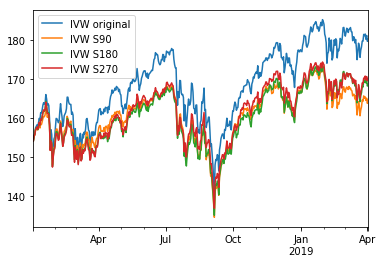

In [12]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.01'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

Again, we would like to see how similar these 3 portfolios perform as the original IBB Index does, but on test dates.

S90 2-norm difference:  171.62325
S180 2-norm difference:  109.6713
S270 2-norm difference:  99.15756


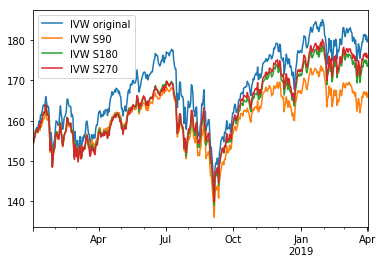

In [43]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.05'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

S90 2-norm difference:  147.54419
S180 2-norm difference:  109.68533
S270 2-norm difference:  85.21064


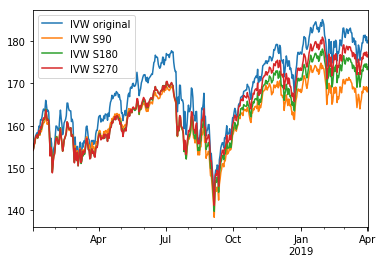

In [45]:
for non_communal in [70, 160, 250]:  
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('model/retrack_s' + str(s) + 'lambda_0.1'+'.h5')
    
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))
    
# plot results and 2-norm differences
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW original', legend=True) 

for s in [90, 180, 270]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='2018/1/2', periods=456, freq='d')).plot(label='IVW S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])  

# Phase 4: Verifying

- x-axis: 2-norm error  
- y-axis: # of stocks in the portfolios: 10, 11, 12, ..., 

From my perspective, Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher MSE.

In [13]:
error = []
lam = 0.01
for non_communal in range(70, 250, 10):  
    
    # some numerical values
    encoding_dim = 64
    s = 20 + non_communal
    stock_index = np.concatenate((ranking[0:20], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(lam))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(lam))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    #consider changing epochs to 1000 and batch size to 40
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))    

Epoch 1/500
1007/1007 [==============================] - 0s 493us/step - loss: 1.1186
Epoch 2/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.8238
Epoch 3/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.7546
Epoch 4/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.7102
Epoch 5/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.6749
Epoch 6/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.6442
Epoch 7/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.6165
Epoch 8/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.5909
Epoch 9/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.5669
Epoch 10/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.5443
Epoch 11/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.5229
Epoch 12/500
1007/1007 [==============================] - 0s 6

1007/1007 [==============================] - 0s 59us/step - loss: 0.0474
Epoch 97/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0469
Epoch 98/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0463
Epoch 99/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0458
Epoch 100/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0453
Epoch 101/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0448
Epoch 102/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0444
Epoch 103/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0440
Epoch 104/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0436
Epoch 105/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0432
Epoch 106/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0428
Epoch 107/500
1007/1007 [==============================] - 0

1007/1007 [==============================] - 0s 55us/step - loss: 0.0334
Epoch 191/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0334
Epoch 192/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0334
Epoch 193/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0334
Epoch 194/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0334
Epoch 195/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0333
Epoch 196/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0333
Epoch 197/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0333
Epoch 198/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0333
Epoch 199/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0333
Epoch 200/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0332
Epoch 201/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 57us/step - loss: 0.0324
Epoch 285/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0324
Epoch 286/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0324
Epoch 287/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0324
Epoch 288/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0324
Epoch 289/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0324
Epoch 290/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0324
Epoch 291/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0324
Epoch 292/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0324
Epoch 293/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0324
Epoch 294/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0324
Epoch 295/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 57us/step - loss: 0.0321
Epoch 379/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0321
Epoch 380/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0321
Epoch 381/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0321
Epoch 382/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0321
Epoch 383/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0321
Epoch 384/500
1007/1007 [==============================] - 0s 55us/step - loss: 0.0321
Epoch 385/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0321
Epoch 386/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0321
Epoch 387/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0321
Epoch 388/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0321
Epoch 389/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 66us/step - loss: 0.0319
Epoch 473/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0319
Epoch 474/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0319
Epoch 475/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0319
Epoch 476/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0319
Epoch 477/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0319
Epoch 478/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0319
Epoch 479/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0319
Epoch 480/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0319
Epoch 481/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0319
Epoch 482/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0319
Epoch 483/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 56us/step - loss: 0.0764
Epoch 68/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0744
Epoch 69/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0725
Epoch 70/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0707
Epoch 71/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0690
Epoch 72/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0674
Epoch 73/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0658
Epoch 74/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0642
Epoch 75/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0628
Epoch 76/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0614
Epoch 77/500
1007/1007 [==============================] - 0s 56us/step - loss: 0.0600
Epoch 78/500
1007/1007 [==============================] - 0s 60us/s

1007/1007 [==============================] - 0s 69us/step - loss: 0.0295
Epoch 162/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0294
Epoch 163/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0294
Epoch 164/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0293
Epoch 165/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0293
Epoch 166/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0292
Epoch 167/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0292
Epoch 168/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0292
Epoch 169/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0291
Epoch 170/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0291
Epoch 171/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0290
Epoch 172/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 68us/step - loss: 0.0278
Epoch 256/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0278
Epoch 257/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0278
Epoch 258/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0278
Epoch 259/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0278
Epoch 260/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0278
Epoch 261/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0277
Epoch 262/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0277
Epoch 263/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0277
Epoch 264/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0277
Epoch 265/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0277
Epoch 266/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 58us/step - loss: 0.0274
Epoch 350/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0274
Epoch 351/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0274
Epoch 352/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0274
Epoch 353/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0274
Epoch 354/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0274
Epoch 355/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0274
Epoch 356/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0274
Epoch 357/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0274
Epoch 358/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0274
Epoch 359/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0274
Epoch 360/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 61us/step - loss: 0.0273
Epoch 444/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0273
Epoch 445/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0273
Epoch 446/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0273
Epoch 447/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0273
Epoch 448/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0273
Epoch 449/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0273
Epoch 450/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0273
Epoch 451/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0273
Epoch 452/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0273
Epoch 453/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0273
Epoch 454/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 67us/step - loss: 0.2023
Epoch 38/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.1952
Epoch 39/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.1883
Epoch 40/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.1817
Epoch 41/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.1754
Epoch 42/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.1693
Epoch 43/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.1634
Epoch 44/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.1579
Epoch 45/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.1525
Epoch 46/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.1473
Epoch 47/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.1424
Epoch 48/500
1007/1007 [==============================] - 0s 63us/s

1007/1007 [==============================] - 0s 60us/step - loss: 0.0305
Epoch 133/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0303
Epoch 134/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0302
Epoch 135/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0301
Epoch 136/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0300
Epoch 137/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0298
Epoch 138/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0297
Epoch 139/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0296
Epoch 140/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0295
Epoch 141/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0294
Epoch 142/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0293
Epoch 143/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 58us/step - loss: 0.0265
Epoch 226/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0265
Epoch 227/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0265
Epoch 228/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0264
Epoch 229/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0264
Epoch 230/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0264
Epoch 231/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0264
Epoch 232/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0264
Epoch 233/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0264
Epoch 234/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0264
Epoch 235/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0264
Epoch 236/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 59us/step - loss: 0.0259
Epoch 320/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0259
Epoch 321/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0259
Epoch 322/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0259
Epoch 323/500
1007/1007 [==============================] - 0s 57us/step - loss: 0.0259
Epoch 324/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0259
Epoch 325/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0259
Epoch 326/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0258
Epoch 327/500
1007/1007 [==============================] - 0s 54us/step - loss: 0.0258
Epoch 328/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0258
Epoch 329/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0258
Epoch 330/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 71us/step - loss: 0.0256
Epoch 414/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0256
Epoch 415/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0256
Epoch 416/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0256
Epoch 417/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0256
Epoch 418/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0256
Epoch 419/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0256
Epoch 420/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0256
Epoch 421/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0256
Epoch 422/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0256
Epoch 423/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0256
Epoch 424/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 71us/step - loss: 0.6542
Epoch 8/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.6271
Epoch 9/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.6016
Epoch 10/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.5774
Epoch 11/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.5544
Epoch 12/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.5325
Epoch 13/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.5115
Epoch 14/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.4915
Epoch 15/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.4724
Epoch 16/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.4540
Epoch 17/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.4365
Epoch 18/500
1007/1007 [==============================] - 0s 65us/ste

1007/1007 [==============================] - 0s 69us/step - loss: 0.0359
Epoch 102/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0354
Epoch 103/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0349
Epoch 104/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0344
Epoch 105/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0340
Epoch 106/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0336
Epoch 107/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0332
Epoch 108/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0328
Epoch 109/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0324
Epoch 110/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0320
Epoch 111/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0317
Epoch 112/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 69us/step - loss: 0.0233
Epoch 196/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0233
Epoch 197/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0233
Epoch 198/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0233
Epoch 199/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0232
Epoch 200/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0232
Epoch 201/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0232
Epoch 202/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0232
Epoch 203/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0232
Epoch 204/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0232
Epoch 205/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0231
Epoch 206/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 67us/step - loss: 0.0225
Epoch 290/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0225
Epoch 291/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0225
Epoch 292/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0225
Epoch 293/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0225
Epoch 294/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0225
Epoch 295/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0225
Epoch 296/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0225
Epoch 297/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0225
Epoch 298/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0225
Epoch 299/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0225
Epoch 300/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 61us/step - loss: 0.0222
Epoch 384/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0222
Epoch 385/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0222
Epoch 386/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0222
Epoch 387/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0222
Epoch 388/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0222
Epoch 389/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0222
Epoch 390/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0222
Epoch 391/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0222
Epoch 392/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0222
Epoch 393/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0222
Epoch 394/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 63us/step - loss: 0.0221
Epoch 478/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0221
Epoch 479/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0221
Epoch 480/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0221
Epoch 481/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0221
Epoch 482/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0221
Epoch 483/500
1007/1007 [==============================] - 0s 58us/step - loss: 0.0221
Epoch 484/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0221
Epoch 485/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0221
Epoch 486/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0221
Epoch 487/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0221
Epoch 488/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 61us/step - loss: 0.0657
Epoch 73/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0639
Epoch 74/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0622
Epoch 75/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0605
Epoch 76/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0589
Epoch 77/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0574
Epoch 78/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0560
Epoch 79/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0546
Epoch 80/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0532
Epoch 81/500
1007/1007 [==============================] - 0s 95us/step - loss: 0.0519
Epoch 82/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0507
Epoch 83/500
1007/1007 [==============================] - 0s 61us/s

1007/1007 [==============================] - 0s 63us/step - loss: 0.0225
Epoch 167/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0224
Epoch 168/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0224
Epoch 169/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0223
Epoch 170/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0223
Epoch 171/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0222
Epoch 172/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0222
Epoch 173/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0222
Epoch 174/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0222
Epoch 175/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0221
Epoch 176/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0221
Epoch 177/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.0211
Epoch 261/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0211
Epoch 262/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0210
Epoch 263/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0210: 0s - loss: 0.021
Epoch 264/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0210
Epoch 265/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0210
Epoch 266/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0210
Epoch 267/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0210
Epoch 268/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0210
Epoch 269/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0210
Epoch 270/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0210
Epoch 271/500
1007/1007 [==============

1007/1007 [==============================] - 0s 59us/step - loss: 0.0207
Epoch 355/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0207
Epoch 356/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0207
Epoch 357/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0207
Epoch 358/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0207
Epoch 359/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0207
Epoch 360/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0207
Epoch 361/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0207
Epoch 362/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0207
Epoch 363/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0207
Epoch 364/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0207
Epoch 365/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 61us/step - loss: 0.0206
Epoch 449/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0206
Epoch 450/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0206
Epoch 451/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0206
Epoch 452/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0206
Epoch 453/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0206
Epoch 454/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0206
Epoch 455/500
1007/1007 [==============================] - 0s 59us/step - loss: 0.0206
Epoch 456/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0206
Epoch 457/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0206
Epoch 458/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0206
Epoch 459/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.1778
Epoch 43/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.1714
Epoch 44/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.1653
Epoch 45/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.1595
Epoch 46/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.1539
Epoch 47/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.1485
Epoch 48/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.1433
Epoch 49/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.1383
Epoch 50/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.1336
Epoch 51/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.1290
Epoch 52/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.1246
Epoch 53/500
1007/1007 [==============================] - 0s 68us/s

Epoch 137/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0241
Epoch 138/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0240
Epoch 139/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0239
Epoch 140/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0238
Epoch 141/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0237
Epoch 142/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0235
Epoch 143/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0234
Epoch 144/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0233
Epoch 145/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0232
Epoch 146/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.0231
Epoch 147/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0231
Epoch 148/500
1007/1007 [==================

1007/1007 [==============================] - 0s 68us/step - loss: 0.0205
Epoch 232/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0205
Epoch 233/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0205
Epoch 234/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0205
Epoch 235/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0205
Epoch 236/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0205
Epoch 237/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0205
Epoch 238/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0205
Epoch 239/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0205
Epoch 240/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0205
Epoch 241/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0205
Epoch 242/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 63us/step - loss: 0.0201
Epoch 326/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0201
Epoch 327/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0201
Epoch 328/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0201
Epoch 329/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0201
Epoch 330/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0201
Epoch 331/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0201
Epoch 332/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0201
Epoch 333/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0201
Epoch 334/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0201
Epoch 335/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0201
Epoch 336/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.0199
Epoch 420/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0199
Epoch 421/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0199
Epoch 422/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0199
Epoch 423/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0199
Epoch 424/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0199
Epoch 425/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0199
Epoch 426/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0199
Epoch 427/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0199
Epoch 428/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0199
Epoch 429/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0199
Epoch 430/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.5595
Epoch 14/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.5375
Epoch 15/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.5164
Epoch 16/500
1007/1007 [==============================] - 0s 81us/step - loss: 0.4962
Epoch 17/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.4769
Epoch 18/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.4584
Epoch 19/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.4406
Epoch 20/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.4236
Epoch 21/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.4073
Epoch 22/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.3917
Epoch 23/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.3766
Epoch 24/500
1007/1007 [==============================] - 0s 60us/s

1007/1007 [==============================] - 0s 60us/step - loss: 0.0311
Epoch 109/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0306
Epoch 110/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0302
Epoch 111/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0298
Epoch 112/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0295
Epoch 113/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0291
Epoch 114/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0287
Epoch 115/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0284
Epoch 116/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0281
Epoch 117/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0278
Epoch 118/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0275
Epoch 119/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 63us/step - loss: 0.0202
Epoch 203/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0202
Epoch 204/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0201
Epoch 205/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0201
Epoch 206/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0201
Epoch 207/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0201: 0s - loss: 0.020
Epoch 208/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0201
Epoch 209/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0201
Epoch 210/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0201
Epoch 211/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0200
Epoch 212/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0200
Epoch 213/500
1007/1007 [==============

1007/1007 [==============================] - 0s 66us/step - loss: 0.0195
Epoch 296/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0195
Epoch 297/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0195
Epoch 298/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0195
Epoch 299/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0195
Epoch 300/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0195
Epoch 301/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0195
Epoch 302/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0195
Epoch 303/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0195
Epoch 304/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0195
Epoch 305/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0194
Epoch 306/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 61us/step - loss: 0.0192
Epoch 390/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0192
Epoch 391/500
1007/1007 [==============================] - 0s 60us/step - loss: 0.0192
Epoch 392/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0192
Epoch 393/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0192
Epoch 394/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0192
Epoch 395/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0192
Epoch 396/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0192
Epoch 397/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0192
Epoch 398/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0192
Epoch 399/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0192
Epoch 400/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 63us/step - loss: 0.0191
Epoch 484/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 485/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 486/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0191
Epoch 487/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0191
Epoch 488/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0191
Epoch 489/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 490/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0191
Epoch 491/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0191
Epoch 492/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 493/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0191
Epoch 494/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 63us/step - loss: 0.0571
Epoch 79/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0555
Epoch 80/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0541
Epoch 81/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0527
Epoch 82/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0513
Epoch 83/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0501
Epoch 84/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0488
Epoch 85/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0476
Epoch 86/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0465
Epoch 87/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0454
Epoch 88/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0444
Epoch 89/500
1007/1007 [==============================] - 0s 66us/s

1007/1007 [==============================] - 0s 65us/step - loss: 0.0204
Epoch 173/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0204
Epoch 174/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0203
Epoch 175/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0203
Epoch 176/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0203
Epoch 177/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0202
Epoch 178/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0202
Epoch 179/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0202
Epoch 180/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0202
Epoch 181/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0201
Epoch 182/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0201
Epoch 183/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.0191
Epoch 267/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0191
Epoch 268/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0191
Epoch 269/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 270/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0191
Epoch 271/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 272/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 273/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 274/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0191
Epoch 275/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0191
Epoch 276/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0191
Epoch 277/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.0188
Epoch 361/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0188
Epoch 362/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0188
Epoch 363/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0188
Epoch 364/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0188
Epoch 365/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0188
Epoch 366/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0188
Epoch 367/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0188
Epoch 368/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0188
Epoch 369/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0188
Epoch 370/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0188
Epoch 371/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 67us/step - loss: 0.0187
Epoch 454/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0187
Epoch 455/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0187
Epoch 456/500
1007/1007 [==============================] - ETA: 0s - loss: 0.019 - 0s 65us/step - loss: 0.0187
Epoch 457/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0187
Epoch 458/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0187
Epoch 459/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0187
Epoch 460/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0187
Epoch 461/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0187
Epoch 462/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0187
Epoch 463/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0187
Epoch 464/500
1007/1007 [========

1007/1007 [==============================] - 0s 67us/step - loss: 0.1576
Epoch 48/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.1520
Epoch 49/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.1466
Epoch 50/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.1415
Epoch 51/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.1365
Epoch 52/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.1318
Epoch 53/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.1272
Epoch 54/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.1228
Epoch 55/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.1186
Epoch 56/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.1146
Epoch 57/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.1107
Epoch 58/500
1007/1007 [==============================] - 0s 63us/s

1007/1007 [==============================] - 0s 65us/step - loss: 0.0220
Epoch 142/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0219
Epoch 143/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0218
Epoch 144/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0217
Epoch 145/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0216
Epoch 146/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0215
Epoch 147/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0214
Epoch 148/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0213
Epoch 149/500
1007/1007 [==============================] - 0s 61us/step - loss: 0.0212
Epoch 150/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0211
Epoch 151/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0210
Epoch 152/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 64us/step - loss: 0.0187
Epoch 236/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0187
Epoch 237/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0187
Epoch 238/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0187
Epoch 239/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0187
Epoch 240/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0187
Epoch 241/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0187
Epoch 242/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0187
Epoch 243/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0187
Epoch 244/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0187
Epoch 245/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0186
Epoch 246/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 73us/step - loss: 0.0184
Epoch 329/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0184
Epoch 330/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0184
Epoch 331/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0184
Epoch 332/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0184
Epoch 333/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0184
Epoch 334/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 335/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0184
Epoch 336/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 337/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0184
Epoch 338/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 339/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 66us/step - loss: 0.0182
Epoch 422/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0182
Epoch 423/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0182
Epoch 424/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0182
Epoch 425/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0182
Epoch 426/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0182
Epoch 427/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0182
Epoch 428/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0182
Epoch 429/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0182
Epoch 430/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0182
Epoch 431/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0182
Epoch 432/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 73us/step - loss: 0.5372
Epoch 16/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.5162
Epoch 17/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.4960
Epoch 18/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.4767
Epoch 19/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.4582
Epoch 20/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.4404
Epoch 21/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.4234
Epoch 22/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.4070
Epoch 23/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.3913
Epoch 24/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.3763
Epoch 25/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.3619
Epoch 26/500
1007/1007 [==============================] - 0s 75us/s

1007/1007 [==============================] - 0s 66us/step - loss: 0.0293
Epoch 110/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0289
Epoch 111/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0284
Epoch 112/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0280
Epoch 113/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0277
Epoch 114/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0273
Epoch 115/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0270
Epoch 116/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0266
Epoch 117/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0263
Epoch 118/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0260
Epoch 119/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0257
Epoch 120/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 65us/step - loss: 0.0185
Epoch 204/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0185
Epoch 205/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 206/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0184
Epoch 207/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0184
Epoch 208/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0184
Epoch 209/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 210/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0184
Epoch 211/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0184
Epoch 212/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0184
Epoch 213/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0183
Epoch 214/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 68us/step - loss: 0.0178
Epoch 297/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0178
Epoch 298/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 299/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 300/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 301/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 302/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 303/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0178
Epoch 304/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 305/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0178
Epoch 306/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0178
Epoch 307/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 67us/step - loss: 0.0176
Epoch 391/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0176
Epoch 392/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0176
Epoch 393/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0176
Epoch 394/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0176
Epoch 395/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0176
Epoch 396/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0176
Epoch 397/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0176
Epoch 398/500
1007/1007 [==============================] - 0s 100us/step - loss: 0.0176
Epoch 399/500
1007/1007 [==============================] - 0s 99us/step - loss: 0.0176
Epoch 400/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0176
Epoch 401/500
1007/1007 [==============================]

1007/1007 [==============================] - 0s 65us/step - loss: 0.0176
Epoch 485/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0176
Epoch 486/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0176
Epoch 487/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0176
Epoch 488/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0176
Epoch 489/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0176
Epoch 490/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0176
Epoch 491/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0175
Epoch 492/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0176
Epoch 493/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0175
Epoch 494/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0175
Epoch 495/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 66us/step - loss: 0.0548
Epoch 80/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0533
Epoch 81/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0518
Epoch 82/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0505
Epoch 83/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0491
Epoch 84/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0479
Epoch 85/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0467
Epoch 86/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0455
Epoch 87/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0444
Epoch 88/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0433
Epoch 89/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0423
Epoch 90/500
1007/1007 [==============================] - 0s 66us/s

1007/1007 [==============================] - 0s 66us/step - loss: 0.0184
Epoch 174/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0184
Epoch 175/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0183
Epoch 176/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0183
Epoch 177/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0183
Epoch 178/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0182
Epoch 179/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0182
Epoch 180/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0182
Epoch 181/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0181
Epoch 182/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0181
Epoch 183/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0181
Epoch 184/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 67us/step - loss: 0.0172
Epoch 268/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0172
Epoch 269/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0172
Epoch 270/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0172
Epoch 271/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0172
Epoch 272/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0172
Epoch 273/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0172
Epoch 274/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0172
Epoch 275/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0172
Epoch 276/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0172
Epoch 277/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0172
Epoch 278/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 66us/step - loss: 0.0170
Epoch 362/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0170
Epoch 363/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 364/500
1007/1007 [==============================] - 0s 62us/step - loss: 0.0170
Epoch 365/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0170
Epoch 366/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0170
Epoch 367/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 368/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0170
Epoch 369/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0170
Epoch 370/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 371/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0170
Epoch 372/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 66us/step - loss: 0.0169
Epoch 455/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0169
Epoch 456/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0169
Epoch 457/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0169
Epoch 458/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0169
Epoch 459/500
1007/1007 [==============================] - 0s 63us/step - loss: 0.0169
Epoch 460/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0169
Epoch 461/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0169
Epoch 462/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0169
Epoch 463/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0169
Epoch 464/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0169
Epoch 465/500
1007/1007 [==============================] 

Epoch 49/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.1470
Epoch 50/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.1417
Epoch 51/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.1366
Epoch 52/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.1318
Epoch 53/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.1272
Epoch 54/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.1227
Epoch 55/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.1184
Epoch 56/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.1143
Epoch 57/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.1104
Epoch 58/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.1066
Epoch 59/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.1030
Epoch 60/500
1007/1007 [==============================

1007/1007 [==============================] - 0s 72us/step - loss: 0.0199
Epoch 144/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0197
Epoch 145/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0196
Epoch 146/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0195
Epoch 147/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.0194
Epoch 148/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0193
Epoch 149/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0192
Epoch 150/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0192
Epoch 151/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0191
Epoch 152/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0190
Epoch 153/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0189
Epoch 154/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.0167
Epoch 238/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0167
Epoch 239/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0167
Epoch 240/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0166
Epoch 241/500
1007/1007 [==============================] - 0s 64us/step - loss: 0.0166
Epoch 242/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0166
Epoch 243/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0166
Epoch 244/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0166
Epoch 245/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0166
Epoch 246/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0166
Epoch 247/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0166
Epoch 248/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 94us/step - loss: 0.0163
Epoch 332/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0163
Epoch 333/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0163
Epoch 334/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0163
Epoch 335/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0163
Epoch 336/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0163
Epoch 337/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0163
Epoch 338/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0163
Epoch 339/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0163
Epoch 340/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.0163
Epoch 341/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0163
Epoch 342/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.0162
Epoch 426/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0162
Epoch 427/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0162
Epoch 428/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0162
Epoch 429/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0162
Epoch 430/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0162
Epoch 431/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0162
Epoch 432/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0162
Epoch 433/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0162
Epoch 434/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0162
Epoch 435/500
1007/1007 [==============================] - 0s 65us/step - loss: 0.0162
Epoch 436/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 74us/step - loss: 0.4740
Epoch 20/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.4555
Epoch 21/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.4378
Epoch 22/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.4208
Epoch 23/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.4045
Epoch 24/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.3889
Epoch 25/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.3739
Epoch 26/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.3595: 0s - loss: 0.362
Epoch 27/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.3457
Epoch 28/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.3324
Epoch 29/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.3197
Epoch 30/500
1007/1007 [=========================

1007/1007 [==============================] - 0s 71us/step - loss: 0.0259
Epoch 115/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0256
Epoch 116/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0252
Epoch 117/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0249
Epoch 118/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0246
Epoch 119/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0242
Epoch 120/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0239
Epoch 121/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0237
Epoch 122/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0234
Epoch 123/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0231
Epoch 124/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0229
Epoch 125/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.0166
Epoch 209/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0166
Epoch 210/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0166
Epoch 211/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0166
Epoch 212/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0165
Epoch 213/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0165
Epoch 214/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0165
Epoch 215/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0165
Epoch 216/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0165
Epoch 217/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0165
Epoch 218/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0165
Epoch 219/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 68us/step - loss: 0.0161
Epoch 303/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0161
Epoch 304/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0161
Epoch 305/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0160
Epoch 306/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0160
Epoch 307/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0160
Epoch 308/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0160
Epoch 309/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0160
Epoch 310/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0160
Epoch 311/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0160
Epoch 312/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0160
Epoch 313/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 73us/step - loss: 0.0159
Epoch 397/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0159
Epoch 398/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0159
Epoch 399/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0159
Epoch 400/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0159
Epoch 401/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0159
Epoch 402/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0159
Epoch 403/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0159
Epoch 404/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0159
Epoch 405/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0159
Epoch 406/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0159
Epoch 407/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 69us/step - loss: 0.0158
Epoch 491/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0158
Epoch 492/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0158
Epoch 493/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0158
Epoch 494/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0158
Epoch 495/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0158
Epoch 496/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0158
Epoch 497/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0158
Epoch 498/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0158
Epoch 499/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0158
Epoch 500/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0158
Epoch 1/500
1007/1007 [==============================] - 

1007/1007 [==============================] - 0s 68us/step - loss: 0.0468
Epoch 86/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0456
Epoch 87/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0444
Epoch 88/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0433
Epoch 89/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0422
Epoch 90/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0411
Epoch 91/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.0401
Epoch 92/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0392
Epoch 93/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0383
Epoch 94/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0374
Epoch 95/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0365
Epoch 96/500
1007/1007 [==============================] - 0s 70us/s

1007/1007 [==============================] - 0s 87us/step - loss: 0.0167
Epoch 180/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0167
Epoch 181/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0167
Epoch 182/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0166
Epoch 183/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0166
Epoch 184/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0166
Epoch 185/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0166
Epoch 186/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0165
Epoch 187/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0165
Epoch 188/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0165
Epoch 189/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0165
Epoch 190/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.0157
Epoch 273/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0157
Epoch 274/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0157
Epoch 275/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0157
Epoch 276/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0157
Epoch 277/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0156
Epoch 278/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0156
Epoch 279/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0156
Epoch 280/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0156
Epoch 281/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0156
Epoch 282/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0156
Epoch 283/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 70us/step - loss: 0.0154
Epoch 367/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0154
Epoch 368/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0154: 0s - loss: 0.016
Epoch 369/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0154
Epoch 370/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0154
Epoch 371/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0154
Epoch 372/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0154
Epoch 373/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0154
Epoch 374/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0154
Epoch 375/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0154
Epoch 376/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0154
Epoch 377/500
1007/1007 [==============

1007/1007 [==============================] - 0s 70us/step - loss: 0.0153
Epoch 461/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0153
Epoch 462/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0153
Epoch 463/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0153
Epoch 464/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0153
Epoch 465/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0153
Epoch 466/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0153
Epoch 467/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0153
Epoch 468/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0153
Epoch 469/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0153
Epoch 470/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0153
Epoch 471/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 78us/step - loss: 0.1209
Epoch 56/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.1166
Epoch 57/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.1126
Epoch 58/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.1087
Epoch 59/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.1049
Epoch 60/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.1013
Epoch 61/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0979
Epoch 62/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0946
Epoch 63/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0914
Epoch 64/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0883
Epoch 65/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0854
Epoch 66/500
1007/1007 [==============================] - 0s 78us/s

1007/1007 [==============================] - 0s 75us/step - loss: 0.0181
Epoch 150/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0180
Epoch 151/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0179
Epoch 152/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0178
Epoch 153/500
1007/1007 [==============================] - 0s 67us/step - loss: 0.0178
Epoch 154/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0177
Epoch 155/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0176
Epoch 156/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0175
Epoch 157/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0175
Epoch 158/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0174
Epoch 159/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0173
Epoch 160/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 71us/step - loss: 0.0155
Epoch 243/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0155
Epoch 244/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0154
Epoch 245/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0154
Epoch 246/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0154
Epoch 247/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0154
Epoch 248/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0154
Epoch 249/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0154
Epoch 250/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0154
Epoch 251/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0154
Epoch 252/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0154
Epoch 253/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 75us/step - loss: 0.0152
Epoch 337/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0152: 0s - loss: 0.015
Epoch 338/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0152
Epoch 339/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0152
Epoch 340/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0152
Epoch 341/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0152
Epoch 342/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0152
Epoch 343/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0152
Epoch 344/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0151
Epoch 345/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0152
Epoch 346/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0151
Epoch 347/500
1007/1007 [==============

1007/1007 [==============================] - 0s 78us/step - loss: 0.0150
Epoch 430/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0150
Epoch 431/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0150
Epoch 432/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0150
Epoch 433/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0150
Epoch 434/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0150
Epoch 435/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0150
Epoch 436/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0150
Epoch 437/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0150
Epoch 438/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0150
Epoch 439/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0150
Epoch 440/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 71us/step - loss: 0.4233
Epoch 24/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.4069
Epoch 25/500
1007/1007 [==============================] - 0s 91us/step - loss: 0.3911
Epoch 26/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.3760
Epoch 27/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.3615
Epoch 28/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.3475
Epoch 29/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.3341
Epoch 30/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.3213
Epoch 31/500
1007/1007 [==============================] - 0s 90us/step - loss: 0.3090
Epoch 32/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.2972
Epoch 33/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.2858
Epoch 34/500
1007/1007 [==============================] - 0s 70us/s

1007/1007 [==============================] - 0s 91us/step - loss: 0.0239
Epoch 119/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0235
Epoch 120/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0232
Epoch 121/500
1007/1007 [==============================] - 0s 94us/step - loss: 0.0229
Epoch 122/500
1007/1007 [==============================] - 0s 90us/step - loss: 0.0226
Epoch 123/500
1007/1007 [==============================] - 0s 91us/step - loss: 0.0223
Epoch 124/500
1007/1007 [==============================] - 0s 97us/step - loss: 0.0221
Epoch 125/500
1007/1007 [==============================] - 0s 96us/step - loss: 0.0218
Epoch 126/500
1007/1007 [==============================] - 0s 107us/step - loss: 0.0215
Epoch 127/500
1007/1007 [==============================] - 0s 91us/step - loss: 0.0213
Epoch 128/500
1007/1007 [==============================] - 0s 94us/step - loss: 0.0211
Epoch 129/500
1007/1007 [==============================]

1007/1007 [==============================] - 0s 79us/step - loss: 0.0153
Epoch 213/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0153
Epoch 214/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0153
Epoch 215/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0153
Epoch 216/500
1007/1007 [==============================] - 0s 95us/step - loss: 0.0153
Epoch 217/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0153
Epoch 218/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.0153
Epoch 219/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0152
Epoch 220/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.0152
Epoch 221/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0152
Epoch 222/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0152
Epoch 223/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 80us/step - loss: 0.0148
Epoch 307/500
1007/1007 [==============================] - 0s 123us/step - loss: 0.0148
Epoch 308/500
1007/1007 [==============================] - 0s 117us/step - loss: 0.0148
Epoch 309/500
1007/1007 [==============================] - 0s 116us/step - loss: 0.0148
Epoch 310/500
1007/1007 [==============================] - 0s 92us/step - loss: 0.0148
Epoch 311/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.0148
Epoch 312/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0148
Epoch 313/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0148
Epoch 314/500
1007/1007 [==============================] - 0s 102us/step - loss: 0.0148
Epoch 315/500
1007/1007 [==============================] - 0s 101us/step - loss: 0.0148
Epoch 316/500
1007/1007 [==============================] - 0s 99us/step - loss: 0.0148
Epoch 317/500
1007/1007 [===========================

1007/1007 [==============================] - 0s 100us/step - loss: 0.0147
Epoch 401/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0147
Epoch 402/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0147
Epoch 403/500
1007/1007 [==============================] - 0s 81us/step - loss: 0.0147
Epoch 404/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0147
Epoch 405/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0147
Epoch 406/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0147
Epoch 407/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0147
Epoch 408/500
1007/1007 [==============================] - 0s 100us/step - loss: 0.0147
Epoch 409/500
1007/1007 [==============================] - 0s 93us/step - loss: 0.0147
Epoch 410/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0147
Epoch 411/500
1007/1007 [==============================

1007/1007 [==============================] - 0s 76us/step - loss: 0.0146
Epoch 495/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0146
Epoch 496/500
1007/1007 [==============================] - 0s 82us/step - loss: 0.0146
Epoch 497/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0146
Epoch 498/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0146
Epoch 499/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0146
Epoch 500/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0146
Epoch 1/500
1007/1007 [==============================] - 1s 851us/step - loss: 1.3558
Epoch 2/500
1007/1007 [==============================] - 0s 88us/step - loss: 1.0272
Epoch 3/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.9588
Epoch 4/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.9111
Epoch 5/500
1007/1007 [==============================] - 0s 81us

1007/1007 [==============================] - 0s 86us/step - loss: 0.0413
Epoch 90/500
1007/1007 [==============================] - 0s 82us/step - loss: 0.0402
Epoch 91/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0392
Epoch 92/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0382
Epoch 93/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0372
Epoch 94/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0363
Epoch 95/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0354
Epoch 96/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0346
Epoch 97/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.0338
Epoch 98/500
1007/1007 [==============================] - 0s 99us/step - loss: 0.0330
Epoch 99/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0322
Epoch 100/500
1007/1007 [==============================] - 0s 71us/

1007/1007 [==============================] - 0s 90us/step - loss: 0.0147
Epoch 184/500
1007/1007 [==============================] - 0s 66us/step - loss: 0.0146
Epoch 185/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0146
Epoch 186/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0146
Epoch 187/500
1007/1007 [==============================] - 0s 102us/step - loss: 0.0146
Epoch 188/500
1007/1007 [==============================] - 0s 68us/step - loss: 0.0145
Epoch 189/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0145
Epoch 190/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0145
Epoch 191/500
1007/1007 [==============================] - 0s 69us/step - loss: 0.0145
Epoch 192/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0144
Epoch 193/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0144
Epoch 194/500
1007/1007 [==============================]

1007/1007 [==============================] - 0s 92us/step - loss: 0.0137
Epoch 278/500
1007/1007 [==============================] - 0s 109us/step - loss: 0.0137
Epoch 279/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0137
Epoch 280/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0137
Epoch 281/500
1007/1007 [==============================] - 0s 99us/step - loss: 0.0137
Epoch 282/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.0137
Epoch 283/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0137
Epoch 284/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0137
Epoch 285/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0137
Epoch 286/500
1007/1007 [==============================] - 0s 120us/step - loss: 0.0137
Epoch 287/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0137
Epoch 288/500
1007/1007 [==============================

Epoch 371/500
1007/1007 [==============================] - 0s 100us/step - loss: 0.0136
Epoch 372/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0136
Epoch 373/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0136
Epoch 374/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0136: 0s - loss: 0.014
Epoch 375/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0136
Epoch 376/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0136
Epoch 377/500
1007/1007 [==============================] - 0s 102us/step - loss: 0.0135
Epoch 378/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0135
Epoch 379/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0135
Epoch 380/500
1007/1007 [==============================] - 0s 82us/step - loss: 0.0135
Epoch 381/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0135
Epoch 382/500
1007/1007

1007/1007 [==============================] - 0s 87us/step - loss: 0.0135
Epoch 465/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.0135
Epoch 466/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0135
Epoch 467/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0135
Epoch 468/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.0135
Epoch 469/500
1007/1007 [==============================] - 0s 94us/step - loss: 0.0135
Epoch 470/500
1007/1007 [==============================] - 0s 70us/step - loss: 0.0135
Epoch 471/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0135
Epoch 472/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0135
Epoch 473/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0135
Epoch 474/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0135
Epoch 475/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 79us/step - loss: 0.1068
Epoch 60/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.1030
Epoch 61/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0995
Epoch 62/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0960
Epoch 63/500
1007/1007 [==============================] - 0s 84us/step - loss: 0.0927
Epoch 64/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0896
Epoch 65/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0865
Epoch 66/500
1007/1007 [==============================] - 0s 91us/step - loss: 0.0836
Epoch 67/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0808
Epoch 68/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0781
Epoch 69/500
1007/1007 [==============================] - 0s 85us/step - loss: 0.0756
Epoch 70/500
1007/1007 [==============================] - 0s 89us/s

1007/1007 [==============================] - 0s 80us/step - loss: 0.0160
Epoch 154/500
1007/1007 [==============================] - 0s 83us/step - loss: 0.0159
Epoch 155/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0158
Epoch 156/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0157
Epoch 157/500
1007/1007 [==============================] - 0s 82us/step - loss: 0.0157
Epoch 158/500
1007/1007 [==============================] - 0s 86us/step - loss: 0.0156
Epoch 159/500
1007/1007 [==============================] - 0s 89us/step - loss: 0.0155
Epoch 160/500
1007/1007 [==============================] - 0s 87us/step - loss: 0.0155
Epoch 161/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0154
Epoch 162/500
1007/1007 [==============================] - 0s 88us/step - loss: 0.0153
Epoch 163/500
1007/1007 [==============================] - 0s 81us/step - loss: 0.0153
Epoch 164/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 83us/step - loss: 0.0136
Epoch 248/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0136
Epoch 249/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0136
Epoch 250/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0136
Epoch 251/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0136
Epoch 252/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0136
Epoch 253/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0136
Epoch 254/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0136
Epoch 255/500
1007/1007 [==============================] - 0s 82us/step - loss: 0.0136
Epoch 256/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0136
Epoch 257/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0136
Epoch 258/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 81us/step - loss: 0.0134
Epoch 342/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0134
Epoch 343/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0134
Epoch 344/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0134
Epoch 345/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0134
Epoch 346/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0134
Epoch 347/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0134
Epoch 348/500
1007/1007 [==============================] - 0s 79us/step - loss: 0.0134
Epoch 349/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0134
Epoch 350/500
1007/1007 [==============================] - 0s 77us/step - loss: 0.0134
Epoch 351/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0134
Epoch 352/500
1007/1007 [==============================] 

1007/1007 [==============================] - 0s 83us/step - loss: 0.0133
Epoch 436/500
1007/1007 [==============================] - 0s 76us/step - loss: 0.0133
Epoch 437/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0133
Epoch 438/500
1007/1007 [==============================] - 0s 74us/step - loss: 0.0133
Epoch 439/500
1007/1007 [==============================] - 0s 73us/step - loss: 0.0133
Epoch 440/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0133
Epoch 441/500
1007/1007 [==============================] - 0s 72us/step - loss: 0.0133
Epoch 442/500
1007/1007 [==============================] - 0s 71us/step - loss: 0.0133
Epoch 443/500
1007/1007 [==============================] - 0s 75us/step - loss: 0.0133
Epoch 444/500
1007/1007 [==============================] - 0s 80us/step - loss: 0.0133
Epoch 445/500
1007/1007 [==============================] - 0s 78us/step - loss: 0.0133
Epoch 446/500
1007/1007 [==============================] 

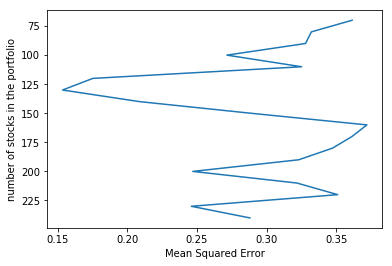

In [14]:
# Plot Efficient Deep Frontier

mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(70, 250, 10)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio') 